In [1]:
import sys
sys.path = ["/eos/user/d/dvalsecc/.local/lib/python3.9/site-packages"] + sys.path
import correctionlib
#!python3 -m pip install git+https://github.com/cms-nanoAOD/correctionlib.git

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import os
from numba import njit

import mplhep as hep
plt.style.use(hep.style.CMS)

In [3]:
inputfile = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/input_truth/electrons/calo_matched_clusters_dataset_v2.hdf5"
outputdir = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/validation_sim_truth/V2/simfraction_electron"
os.makedirs(outputdir, exist_ok=True)

In [3]:
store_ele = pd.HDFStore(inputfile)
df =store_ele['df']
store_ele.close()
df.rename(columns={"output.csv":"window_index"}, inplace=True)
df = df.iloc[:-1]

In [4]:
from joblib import Parallel, delayed
import multiprocessing

def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for name, group in dfGrouped)
    return pd.DataFrame(retLst)

# Having a look at the dataset
It contains all the cluster around each caloparticle. 
Both the clusters inside and output the "dynamic window" limits are included, so that all the truth level info can be analyzed.

In [29]:
df

window_index         en         et  ieta   iphi       eta       phi  \
0         laptopeg  31.886883  30.240940  19.0   87.0  0.328454  1.340380   
1         laptopeg   0.246860   0.230115  22.0   89.0  0.379216  1.372533   
2         vercckuy  20.618114   5.466102  54.0   80.0  2.002698  1.467633   
3         vercckuy   4.233109   1.108452  52.0   80.0  2.015519  1.530647   
4         vercckuy   3.215036   0.847789  58.0   79.0  2.008254  1.313471   
...            ...        ...        ...   ...    ...       ...       ...   
56539     dzqcwgsl   0.600042   0.290390 -78.0  316.0 -1.354435 -0.954206   
56540     dzqcwgsl   0.507719   0.252988 -76.0  335.0 -1.320927 -0.622315   
56541     xuxqjpdn  34.401081  20.340325  64.0  160.0  1.116859  2.608002   
56542     xuxqjpdn   1.310546   0.768749  65.0  163.0  1.126699  2.673575   
56543     xuxqjpdn   1.094105   0.641972  65.0  153.0  1.126343  2.488657   

        iz  simfrac_sig  simen_sig  ...  obsPU  calo_simen  calo_simet  \
0      0.0     0.927512  30.114339  ...   65.0   32.467865   30.794873   
1      0.0     0.000322   0.010452  ...   65.0   32.467865   30.794873   
2      1.0     0.450696  18.343793  ...   65.0   40.621811   10.661895   
3      1.0     0.097994   3.988479  ...   65.0   40.621811   10.661895   
4      1.0     0.092990   3.784809  ...   65.0   40.621811   10.661895   
...    ...          ...        ...  ...    ...         ...         ...   
56539  0.0     0.006075   0.505064  ...   80.0   83.134552   41.496276   
56540  0.0     0.004093   0.340250  ...   80.0   83.134552   41.496276   
56541  0.0     0.851447  33.857297  ...   80.0   39.760387   23.486508   
56542  0.0     0.037422   1.488078  ...   80.0   39.760387   23.486508   
56543  0.0     0.022650   0.900665  ...   80.0   39.760387   23.486508   

       calo_simen_good  calo_geneta  calo_genphi  calo_simeta  calo_simphi  \
0            32.467865     0.326505     1.317062     0.328153     1.340467   
1            32.467865     0.326505     1.317062     0.328153     1.340467   
2            40.563438     2.002744     1.417972     2.013091     1.448383   
3            40.563438     2.002744     1.417972     2.013091     1.448383   
4            40.563438     2.002744     1.417972     2.013091     1.448383   
...                ...          ...          ...          ...          ...   
56539        83.120613    -1.322460    -0.713246    -1.318931    -0.695952   
56540        83.120613    -1.322460    -0.713246    -1.318931    -0.695952   
56541        39.752342     1.113623     2.576075     1.118052     2.605700   
56542        39.752342     1.113623     2.576075     1.118052     2.605700   
56543        39.752342     1.113623     2.576075     1.118052     2.605700   

       calo_genen  calo_genet  
0       32.832268   31.156721  
1       32.832268   31.156721  
2       56.682503   15.026533  
3       56.682503   15.026533  
4       56.682503   15.026533  
...           ...         ...  
56539   86.523537   43.055962  
56540   86.523537   43.055962  
56541   42.410969   25.141815  
56542   42.410969   25.141815  
56543   42.410969   25.141815  

[5697183 rows x 35 columns]

# Building the window

Collecting all the clusters around the same seed by the window_index columns. 
The `calo_match_dataset.py` script collects all the clusters with some caloparticle deposition around each seed. 
The seed in this case is the PFCluster with the highest score for each caloparticle. 

In [6]:
seed = df[(df.is_seed==1)][['window_index','en','eta','et', 'simfrac_sig']]
seed.columns = ['window_index','seed_en','seed_eta','seed_et','seed_simfrac_sig']

dfa = df.join(seed.set_index("window_index"), on='window_index')

# Requiring a minimum of 1% of simFraction for the seeds for quality
dfb = dfa[(dfa.seed_simfrac_sig > 0.01)]  # Do now require any geometrical window limit  & (dfa.in_window)

(array([ 9422., 20166., 19600., 17632., 15243., 13912., 13330., 12925.,
        12537., 12041., 11813., 11548., 11368., 11218., 11011., 10926.,
        10669., 10460., 10357., 10354., 10309., 10170., 10056.,  9823.,
         9589.,  9540.,  9620.,  9529.,  9261.,  9268.,  9280.,  9395.,
         9067.,  9207.,  9175.,  8906.,  9096.,  8661.,  8722.,  8687.,
         8960.,  8633.,  8813.,  8413.,  8503.,  8537.,  8433.,  8584.,
         8452.,  8396.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
         4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
         8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. , 12.4, 12.8,
        13.2, 13.6, 14. , 14.4, 14.8, 15.2, 15.6, 16. , 16.4, 16.8, 17.2,
        17.6, 18. , 18.4, 18.8, 19.2, 19.6, 20. ]),
 <BarContainer object of 50 artists>)

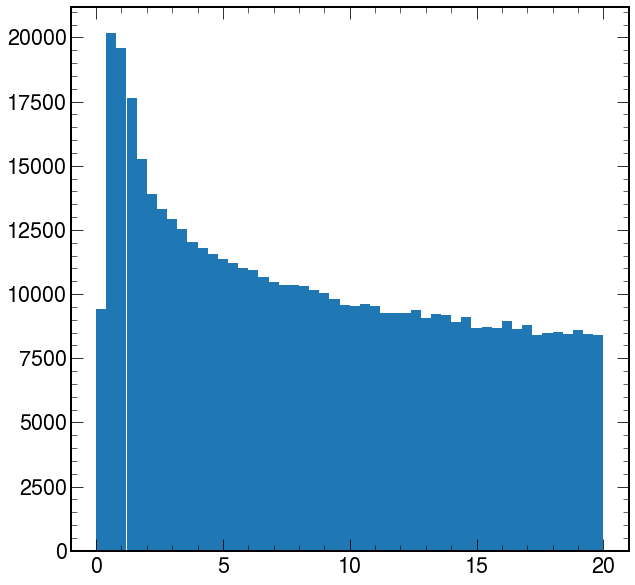

In [8]:
plt.hist(dfb[dfb.is_seed==1].seed_et, bins=50, range=(0,20))

(array([[1340.,  492.,  560., ...,  555.,  365.,  850.],
        [2198.,  800.,  852., ...,  851.,  844., 1870.],
        [ 830.,  620.,  686., ...,  689.,  620.,  723.],
        ...,
        [ 426.,  586.,  549., ...,  518.,  580.,  414.],
        [ 418.,  540.,  548., ...,  540.,  603.,  387.],
        [ 417.,  537.,  542., ...,  566.,  556.,  387.]]),
 array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ,  4.8,  5.6,  6.4,  7.2,  8. ,
         8.8,  9.6, 10.4, 11.2, 12. , 12.8, 13.6, 14.4, 15.2, 16. , 16.8,
        17.6, 18.4, 19.2, 20. , 20.8, 21.6, 22.4, 23.2, 24. , 24.8, 25.6,
        26.4, 27.2, 28. , 28.8, 29.6, 30.4, 31.2, 32. , 32.8, 33.6, 34.4,
        35.2, 36. , 36.8, 37.6, 38.4, 39.2, 40. ]),
 array([-3. , -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. ,
        -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,
         1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ]),
 <matplotlib.collections.QuadMesh at 0x7fa935b57760>)

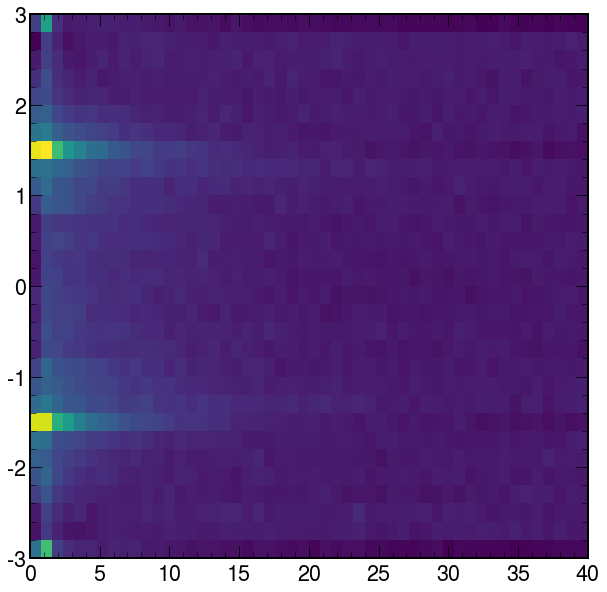

In [9]:
plt.hist2d(dfb[dfb.is_seed==1].seed_et, dfb[dfb.is_seed==1].seed_eta, bins=(50, 30), range=((0,40), (-3,3)))

# Window dimension study

In [10]:
H, phibins , etabins  = np.histogram2d(dfb[dfb.is_seed==0].dphi_seed, dfb[dfb.is_seed==0].deta_seed, 
                          range=((-0.95, 0.95), (-0.4, 0.5)), bins=(51,51))
Hfrac, _ ,_  = np.histogram2d(dfb[dfb.is_seed==0].dphi_seed, dfb[dfb.is_seed==0].deta_seed, 
                              weights=dfb[dfb.is_seed==0].simen_sig, 
                          range=((-0.95, 0.95), (-0.4, 0.5)), bins=(51,51))

X, Y = np.meshgrid(phibins, etabins)

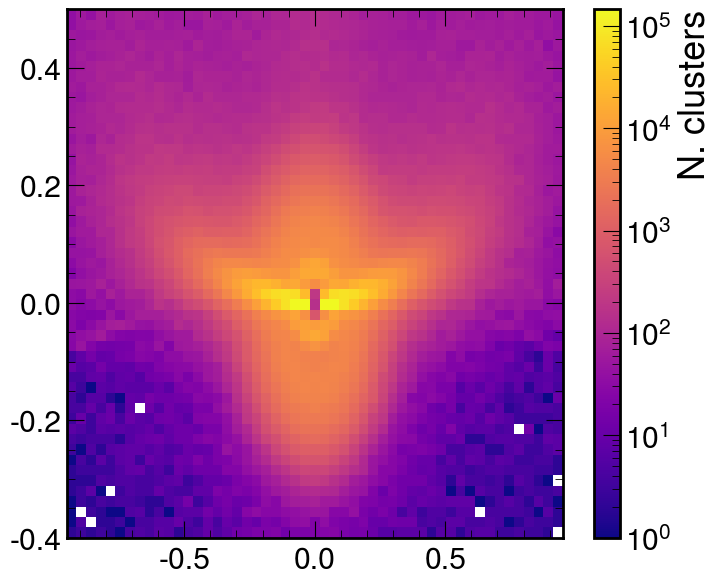

In [11]:
plt.figure(figsize=(8,7), dpi=100)
I = plt.pcolormesh(X, Y, H.T, norm=LogNorm(), cmap="plasma")
plt.colorbar(I, label="N. clusters")

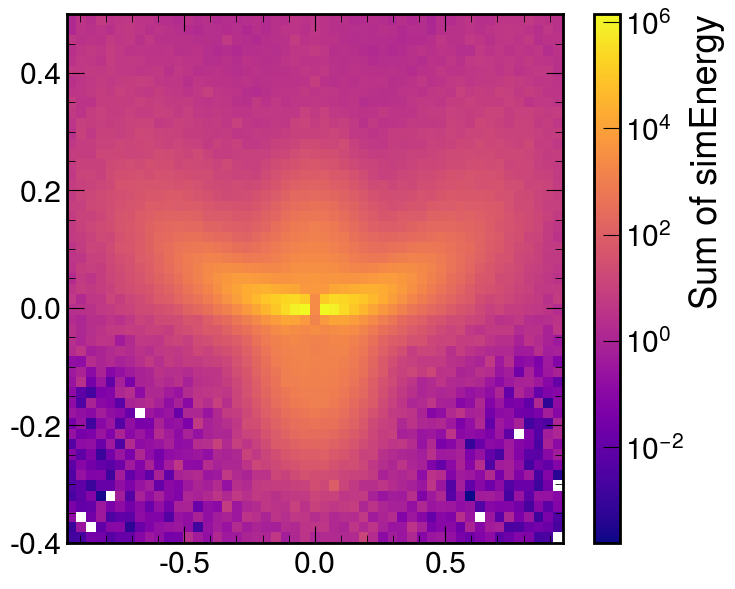

In [12]:
plt.figure(figsize=(8,7), dpi=100)

I = plt.pcolormesh(X, Y, Hfrac.T, norm=LogNorm(), cmap="plasma")
plt.colorbar(label="Sum of simEnergy")

Plotting the normalized distribution of the profiled simEnergy in each bin

/tmp/ipykernel_1113/4061902690.py:2: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)


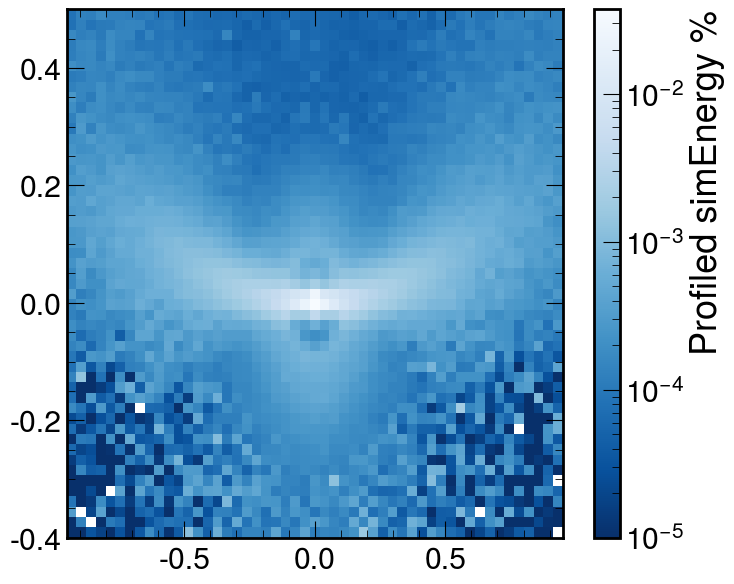

In [13]:
plt.figure(figsize=(8,7), dpi=100)
profile_simen = (Hfrac/H)
np.nan_to_num(profile_simen, copy=False, nan=0.)
prof_simen_perc = profile_simen / np.sum(profile_simen)

I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-5), cmap="Blues_r")
plt.colorbar(label="Profiled simEnergy %")

#$plt.gca().set_xticklabels(phibins)

Plotting the normalized distribution of the profiled simEnergy/caloEn in each bin

/tmp/ipykernel_1113/2531401568.py:10: RuntimeWarning: invalid value encountered in true_divide
  profile_simen2 = (Hfrac2/H2)


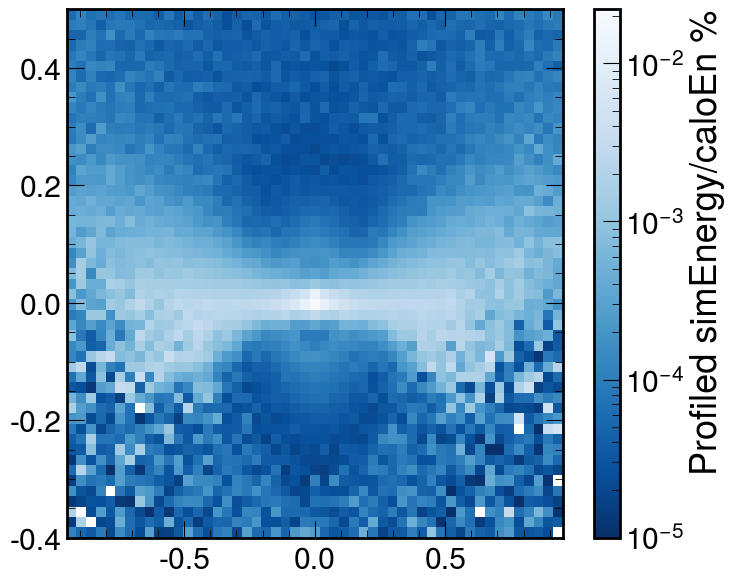

In [14]:
H2, phibins , etabins  = np.histogram2d(dfb[dfb.is_seed==0].dphi_seed, dfb[dfb.is_seed==0].deta_seed, 
                          range=((-0.95, 0.95), (-0.4, 0.5)), bins=(51,51))
Hfrac2, _ ,_  = np.histogram2d(dfb[dfb.is_seed==0].dphi_seed, dfb[dfb.is_seed==0].deta_seed, 
                              weights=dfb[dfb.is_seed==0].simen_sig/dfb[dfb.is_seed==0].calo_simen_good, 
                          range=((-0.95, 0.95), (-0.4, 0.5)), bins=(51,51))

X, Y = np.meshgrid(phibins, etabins)

plt.figure(figsize=(8,7), dpi=100)
profile_simen2 = (Hfrac2/H2)
np.nan_to_num(profile_simen2, copy=False, nan=0.)
prof_simen_perc2 = profile_simen2 / np.sum(profile_simen2)

I = plt.pcolormesh(X, Y, prof_simen_perc2.T, norm=LogNorm(vmin=1e-5), cmap="Blues_r")
plt.colorbar(label="Profiled simEnergy/caloEn %")

#$plt.gca().set_xticklabels(phibins)

### Studying the profile

In [15]:
import numba 
@numba.njit
def get_binrange(X, perc, direction=1):
    S = 0.
    i = 0 if direction>0 else len(X)-1
    while(S<perc):
        S += X[i]
        i += direction
    return i

Text(1, 0, 'ieta, (iphi profiled)')

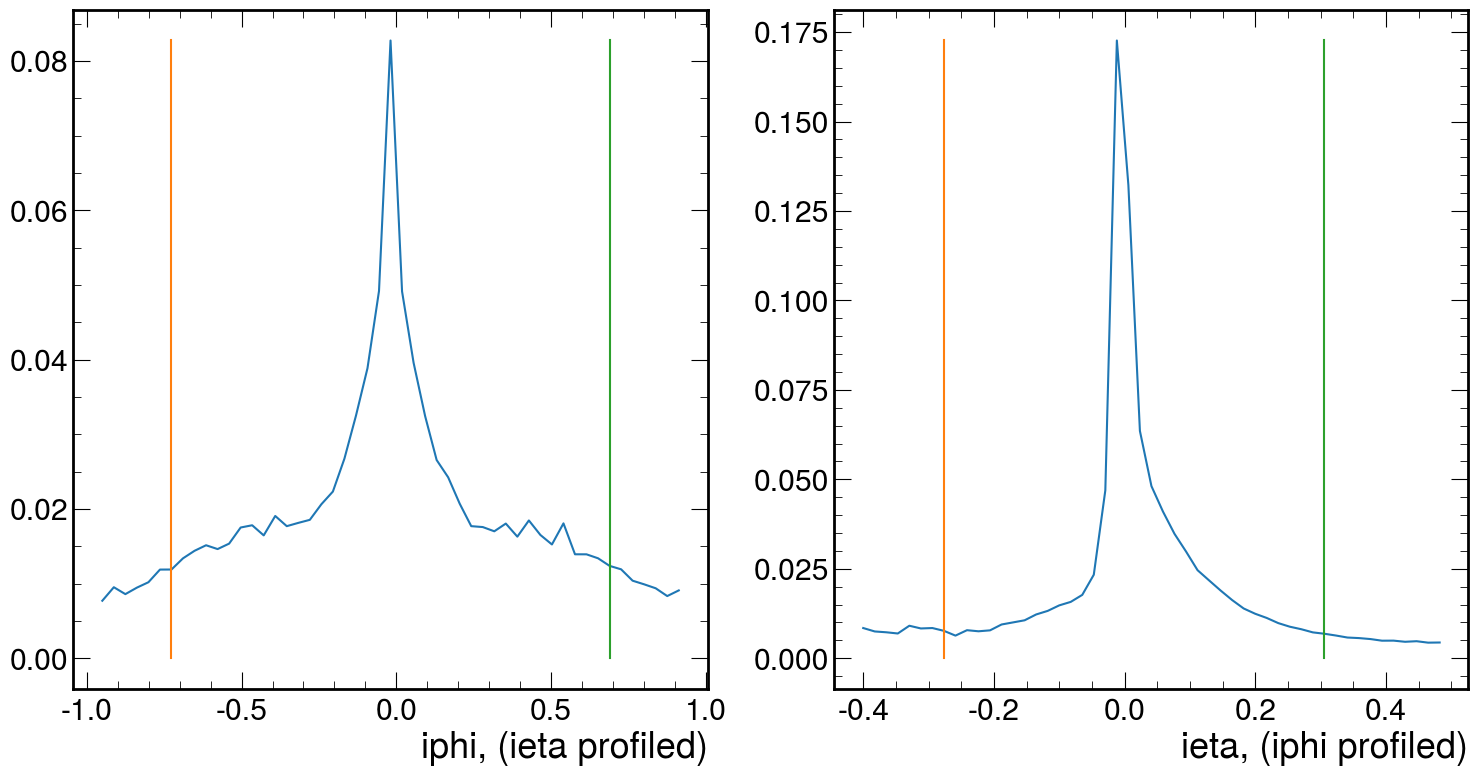

In [17]:
iphi_profile = np.sum(prof_simen_perc, axis=1)
ieta_profile = np.sum(prof_simen_perc.T, axis=1)

prob = 0.05
iphi_min =  get_binrange(iphi_profile,  prob)
iphi_max =  get_binrange(iphi_profile, prob, direction=-1)
ieta_min =  get_binrange(ieta_profile,  prob)
ieta_max =  get_binrange(ieta_profile, prob, direction=-1)

f, (a1, a2) = plt.subplots(1,2, figsize=(18,9), dpi=100)
a1.plot(phibins[:-1], iphi_profile)
a2.plot(etabins[:-1], ieta_profile)
a1.plot([phibins[iphi_min], phibins[iphi_min]], [0,np.max(iphi_profile)])
a1.plot([phibins[iphi_max], phibins[iphi_max]], [0,np.max(iphi_profile)])
a2.plot([etabins[ieta_min], etabins[ieta_min]], [0,np.max(ieta_profile)])
a2.plot([etabins[ieta_max], etabins[ieta_max]], [0,np.max(ieta_profile)])

a1.set_xlabel("iphi, (ieta profiled)")
a2.set_xlabel("ieta, (iphi profiled)")

## Now we do the same in bins of eta

In [18]:
eta_bins_wind = [0.0, 0.2, 0.4, 0.7, 1.0, 1.15, 1.3, 1.4442, 1.566, 1.75, 2.0, 2.4, 3.0]

dfb["eta_bin"] = pd.cut(dfb["seed_eta"].abs(), eta_bins_wind, labels=list(range(len(eta_bins_wind)-1)))

/tmp/ipykernel_1113/1576785483.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb["eta_bin"] = pd.cut(dfb["seed_eta"].abs(), eta_bins_wind, labels=list(range(len(eta_bins_wind)-1)))


### Plotting simEn profiles

/tmp/ipykernel_1113/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1

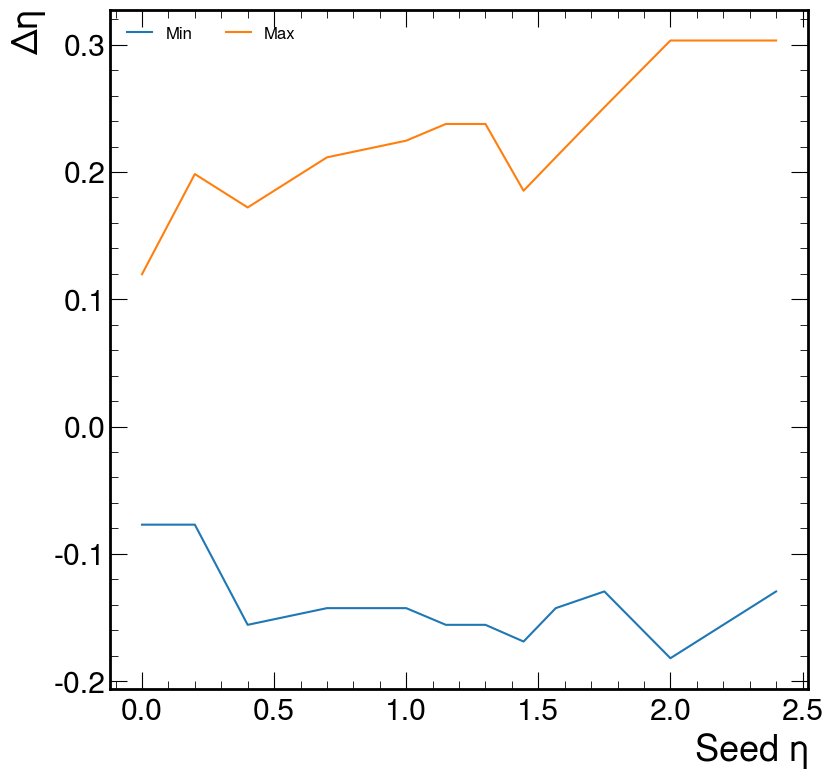

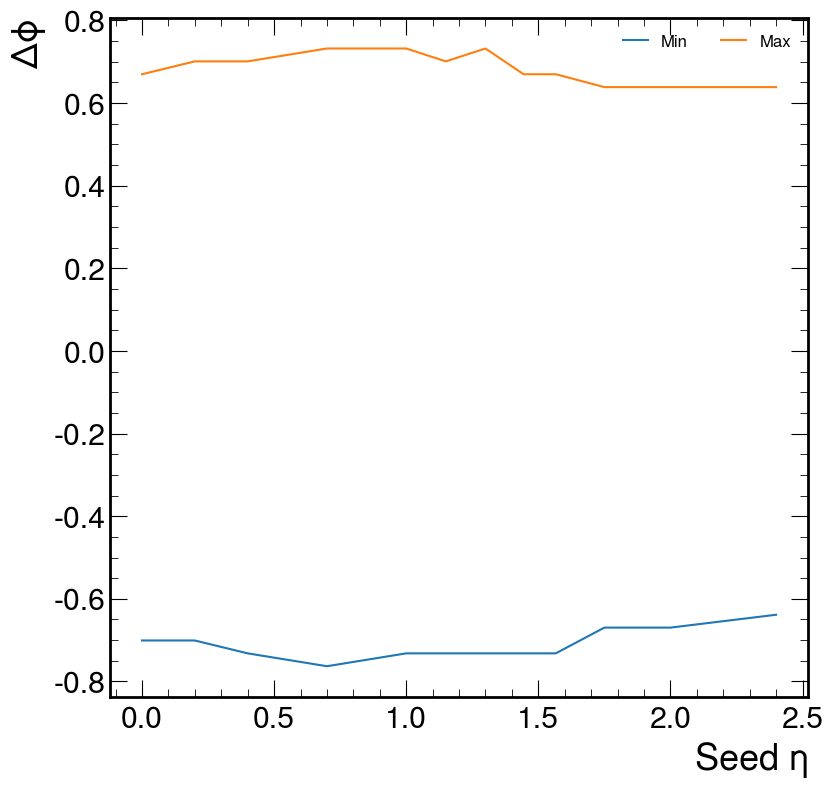

In [19]:
outputdirwind = outputdir + "/windows_simEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_analysis(prob_phi, prob_eta):
    def f(dfs):
        df = dfs[dfs.is_seed ==0]
        H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
        Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                                  weights=df.simen_sig,  # --> simEN
                              range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
        
        
        X, Y = np.meshgrid(phibins, etabins)
        
        profile_simen = (Hfrac/H)
        np.nan_to_num(profile_simen, copy=False, nan=0.)
        prof_simen_perc = profile_simen / np.sum(profile_simen)
        
        iphi_profile = np.sum(prof_simen_perc, axis=1)
        ieta_profile = np.sum(prof_simen_perc.T, axis=1)

        iphi_min =  phibins[get_binrange(iphi_profile,  prob_phi)]
        iphi_max =  phibins[get_binrange(iphi_profile, prob_phi, direction=-1)]
        ieta_min =  etabins[get_binrange(ieta_profile,  prob_eta[0])]
        ieta_max =  etabins[get_binrange(ieta_profile, prob_eta[1], direction=-1)]
        
        
        f, (a1, a2) = plt.subplots(1,2, figsize=(18,9), dpi=100)
        a1.plot(phibins[:-1], iphi_profile)
        a2.plot(etabins[:-1], ieta_profile)
        a1.plot([iphi_min,iphi_min], [0,np.max(iphi_profile)])
        a1.plot([iphi_max, iphi_max], [0,np.max(iphi_profile)])
        a2.plot([ieta_min, ieta_min], [0,np.max(ieta_profile)])
        a2.plot([ieta_max, ieta_max], [0,np.max(ieta_profile)])
        a1.set_xlabel("iphi, (ieta profiled)")
        a2.set_xlabel("ieta, (iphi profiled)")
        f.savefig(outputdirwind+f"/simen_profile_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
        f.savefig(outputdirwind+f"/simen_profile_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
        plt.close(f)
        
        f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
        I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
        rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                                 linewidth=2, edgecolor='orange', facecolor='none')
        ax.add_patch(rect)
        plt.colorbar(I, label="Profiled simEnergy %", ax=ax)
        ax.set_xlabel("$\Delta\phi$")
        ax.set_ylabel("$\Delta\eta$")
        f.savefig(outputdirwind+f"/simen_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
        f.savefig(outputdirwind+f"/simen_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
        plt.close(f)
        
        return pd.Series({
            "iphi_min" : iphi_min,
            "iphi_max" : iphi_max,
            "ieta_min" : ieta_min, 
            "ieta_max" : ieta_max, 
        })
    return f


prob_phi = 0.05
prob_eta = [0.05,0.07]
res = dfb.groupby("eta_bin").apply(windows_size_analysis(prob_phi, prob_eta))
res.reset_index(level=0, inplace=True)


# Plotting the limits
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
ax.plot(eta_bins_wind[:-1], res.ieta_min, label="Min")
ax.plot(eta_bins_wind[:-1], res.ieta_max, label="Max")

ax.legend(ncol=3, fontsize="12")
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\eta$")
f.savefig(outputdirwind+"/wind_dimension_deta.png")
f.savefig(outputdirwind+"/wind_dimension_deta.pdf")


f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)

ax.plot(eta_bins_wind[:-1], res.iphi_min, label="Min")
ax.plot(eta_bins_wind[:-1], res.iphi_max, label="Max")

ax.legend(ncol=3, fontsize="12")
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\phi$")
f.savefig(outputdirwind+"/wind_dimension_dphi.png")
f.savefig(outputdirwind+"/wind_dimension_dphi.pdf")

#### Plotting by simEn/CaloEn profiled

/tmp/ipykernel_1113/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1

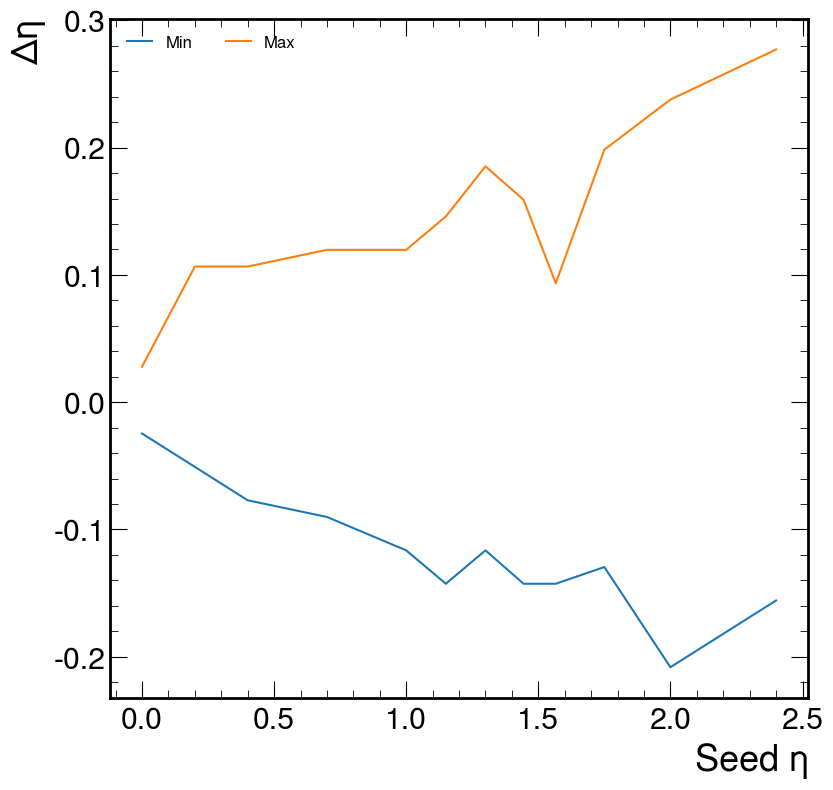

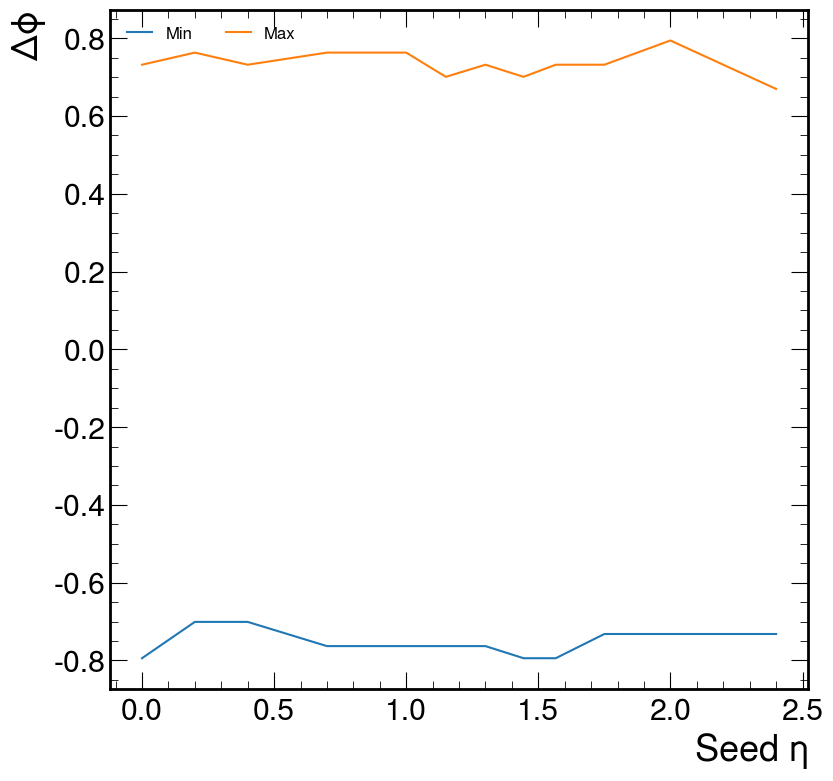

In [20]:
outputdirwind = outputdir + "/windows_simEn_ov_caloEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_analysis(prob_phi, prob_eta):
    def f(dfs):
        df = dfs[dfs.is_seed ==0]
        H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
    
        Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                                  weights=df.simen_sig/df.calo_simen_good,  # ===> simEn/CaloEN
                              range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
        
        X, Y = np.meshgrid(phibins, etabins)
        
        profile_simen = (Hfrac/H)
        np.nan_to_num(profile_simen, copy=False, nan=0.)
        prof_simen_perc = profile_simen / np.sum(profile_simen)
        
        iphi_profile = np.sum(prof_simen_perc, axis=1)
        ieta_profile = np.sum(prof_simen_perc.T, axis=1)

        iphi_min =  phibins[get_binrange(iphi_profile,  prob_phi)]
        iphi_max =  phibins[get_binrange(iphi_profile, prob_phi, direction=-1)]
        ieta_min =  etabins[get_binrange(ieta_profile,  prob_eta[0])]
        ieta_max =  etabins[get_binrange(ieta_profile, prob_eta[1], direction=-1)]
        
        
        f, (a1, a2) = plt.subplots(1,2, figsize=(18,9), dpi=100)
        a1.plot(phibins[:-1], iphi_profile)
        a2.plot(etabins[:-1], ieta_profile)
        a1.plot([iphi_min,iphi_min], [0,np.max(iphi_profile)])
        a1.plot([iphi_max, iphi_max], [0,np.max(iphi_profile)])
        a2.plot([ieta_min, ieta_min], [0,np.max(ieta_profile)])
        a2.plot([ieta_max, ieta_max], [0,np.max(ieta_profile)])
        a1.set_xlabel("iphi, (ieta profiled)")
        a2.set_xlabel("ieta, (iphi profiled)")
        f.savefig(outputdirwind+f"/simen_profile_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
        f.savefig(outputdirwind+f"/simen_profile_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
        plt.close(f)
        
        f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
        I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
        rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                                 linewidth=2, edgecolor='orange', facecolor='none')
        ax.add_patch(rect)
        plt.colorbar(I, label="Profiled simEnergy/CaloEn %", ax=ax)
        ax.set_xlabel("$\Delta\phi$")
        ax.set_ylabel("$\Delta\eta$")
        f.savefig(outputdirwind+f"/simen_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
        f.savefig(outputdirwind+f"/simen_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
        plt.close(f)
        
        return pd.Series({
            "iphi_min" : iphi_min,
            "iphi_max" : iphi_max,
            "ieta_min" : ieta_min, 
            "ieta_max" : ieta_max, 
        })
    return f


prob_phi = 0.05
prob_eta = [0.05,0.07]
res = dfb.groupby("eta_bin").apply(windows_size_analysis(prob_phi, prob_eta))
res.reset_index(level=0, inplace=True)


# Plotting the limits
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
ax.plot(eta_bins_wind[:-1], res.ieta_min, label="Min")
ax.plot(eta_bins_wind[:-1], res.ieta_max, label="Max")

ax.legend(ncol=3, fontsize="12")
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\eta$")
f.savefig(outputdirwind+"/wind_dimension_deta.png")
f.savefig(outputdirwind+"/wind_dimension_deta.pdf")


f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)

ax.plot(eta_bins_wind[:-1], res.iphi_min, label="Min")
ax.plot(eta_bins_wind[:-1], res.iphi_max, label="Max")

ax.legend(ncol=3, fontsize="12")
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\phi$")
f.savefig(outputdirwind+"/wind_dimension_dphi.png")
f.savefig(outputdirwind+"/wind_dimension_dphi.pdf")

#### Approximate the trend as a linear function

In [21]:
def deta_window(seed_eta):
    EB_max = (0.1/1.5)*seed_eta + 0.1
    EB_min = np.ones_like(seed_eta) * (-0.1)
    EE_max = (0.1/1.5)*(seed_eta-1.5) + 0.2 
    EE_min = -0.1 + (-0.1/1.5)*(seed_eta-1.5)
    out_max = np.where(seed_eta<= 1.5, EB_max, EE_max)
    out_min = np.where(seed_eta<= 1.5, EB_min, EE_min)
    return out_max, out_min

@njit
def dphi_window(seed_eta):
    return 0.7 + (-0.1/3)*seed_eta,  -0.7 + (0.1/3)*seed_eta



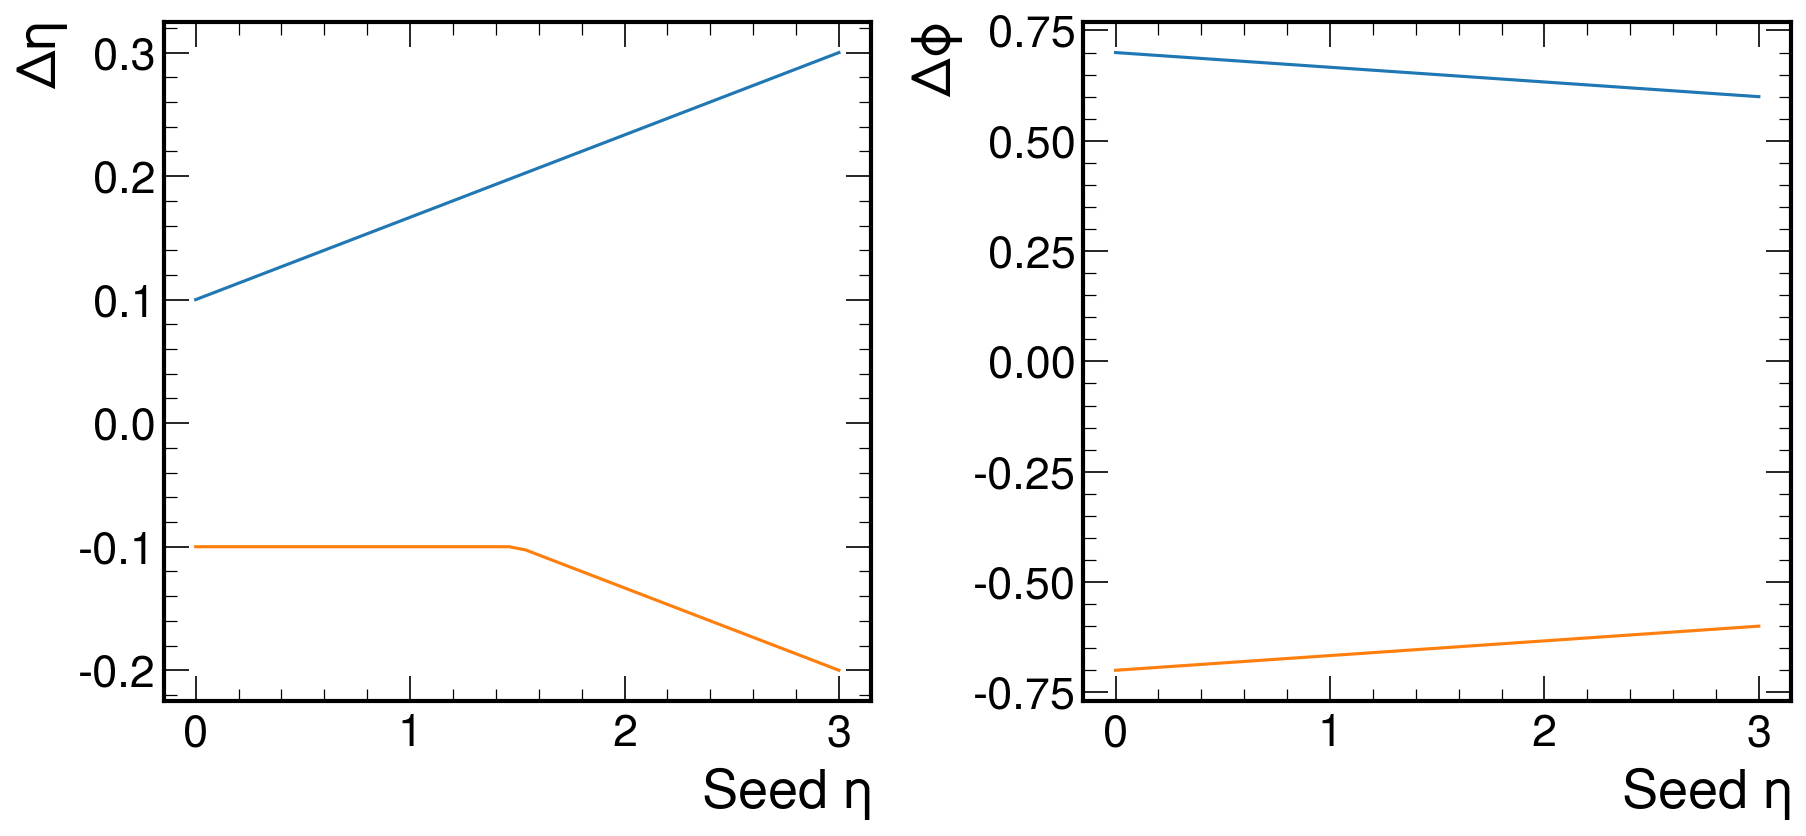

In [23]:
fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=150)
plt.subplots_adjust(wspace=0.3)
seta = np.linspace(0, 3, 40)
emax, emin = deta_window(seta)
pmax, pmin = dphi_window(seta)
ax.plot(seta, emax)
ax.plot(seta, emin)
ax.set_ylabel("$\Delta\eta$")
ax.set_xlabel("Seed $\eta$")

ay.plot(seta, pmax)
ay.plot(seta, pmin)
ay.set_ylabel("$\Delta\phi$")
ay.set_xlabel("Seed $\eta$")\

outputdirwind = outputdir + "/windows_simEn_ov_caloEn"
fig.savefig(outputdirwind+"/final_window.png")
fig.savefig(outputdirwind+"/final_window.pdf")


outputdirwind = outputdir + "/windows_simEn"
fig.savefig(outputdirwind+"/final_window.png")
fig.savefig(outputdirwind+"/final_window.pdf")

### Plots of the window with the final cut
Doing it both for simEn profile and also for simEn/CaloEn profile

In [24]:
outputdirwind = outputdir + "/windows_simEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_final_plot(dfs):
    df = dfs[dfs.is_seed ==0]
    H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
    Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              weights=df.simen_sig,  # --> simEN
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))

    X, Y = np.meshgrid(phibins, etabins)

    profile_simen = (Hfrac/H)
    np.nan_to_num(profile_simen, copy=False, nan=0.)
    prof_simen_perc = profile_simen / np.sum(profile_simen)

    etacenter = (eta_bins_wind[dfs.eta_bin.values[0]] + eta_bins_wind[dfs.eta_bin.values[0]+1])/2
    iphi_max, iphi_min = dphi_window(etacenter)
    ieta_max, ieta_min = deta_window(etacenter)

    # Profiled simEn
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Profiled simEnergy %", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    # Occupancy
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, H.T/np.sum(H), norm=LogNorm(vmin=1e-4), cmap="Blues")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Occupancy", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    
dfb.groupby("eta_bin").apply(windows_size_final_plot)

/tmp/ipykernel_1113/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1

Empty DataFrame
Columns: []
Index: []

In [25]:
outputdirwind = outputdir + "/windows_simEn_ov_caloEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_final_plot(dfs):
    df = dfs[dfs.is_seed ==0]
    H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
    Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              weights=df.simen_sig/df.calo_simen_good, # --> simEn/CaloEN 
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))

    X, Y = np.meshgrid(phibins, etabins)

    profile_simen = (Hfrac/H)
    np.nan_to_num(profile_simen, copy=False, nan=0.)
    prof_simen_perc = profile_simen / np.sum(profile_simen)

    etacenter = (eta_bins_wind[dfs.eta_bin.values[0]] + eta_bins_wind[dfs.eta_bin.values[0]+1])/2
    iphi_max, iphi_min = dphi_window(etacenter)
    ieta_max, ieta_min = deta_window(etacenter)

    # Profiled simEn
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Profiled simEnergy/caloEn %", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    # Occupancy
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, H.T/np.sum(H), norm=LogNorm(vmin=1e-4), cmap="Blues")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Occupancy", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    
dfb.groupby("eta_bin").apply(windows_size_final_plot)

/tmp/ipykernel_1113/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_1113/1992

Empty DataFrame
Columns: []
Index: []

# Resolution study

Let's study the best threshold for resolution. 
We have to apply the window definition before studying the best threshold.

Get the "seed", in this case the clusters with the highest score for the caloparticle, 
and collect the clusters around them and **apply** the geometrical window we have defined as a function of the seed eta

In [26]:
eta_max, eta_min = deta_window(dfb.seed_eta.abs().values)
phi_max, phi_min = dphi_window(dfb.seed_eta.abs().values)

dfb["in_window_new"] =  (dfb.deta_seed >= eta_min) & (dfb.deta_seed <= eta_max ) & \
                        (dfb.dphi_seed >= phi_min) & (dfb.dphi_seed <= phi_max)    

/tmp/ipykernel_1113/3615905916.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb["in_window_new"] =  (dfb.deta_seed >= eta_min) & (dfb.deta_seed <= eta_max ) & \


Analyzing the truth level resolution for clusters in the geometrical window

In [27]:
def bin_analysis(group):
    ratio_left = group["EoEtrue"].quantile(0.16)
    ratio_right = group["EoEtrue"].quantile(0.84)
    ratio_mean = group[(group.EoEtrue >= ratio_left) & (group.EoEtrue <= ratio_right) ].EoEtrue.mean()
    count = group["EoEtrue"].count()
    return pd.Series(  
        { 
             "quantile_down": ratio_left,
             "quantile_up": ratio_right,
             "EoEtrue_68scale": ratio_mean,
             "EoEtrue_68width": (ratio_right-ratio_left)/2, 
             #"EoEtrue_68width": abs(ratio_right- ratio_left), 
             "EoEtrue_scale":  group.EoEtrue.mean(),
             "EoEtrue_rms":  group.EoEtrue.std(),
             "rel_err" : 1/np.sqrt(count)
        })


In [4]:
etas = [0.0, 0.2, 0.4, 0.7, 1.0, 1.15, 1.3, 1.4442, 1.566, 1.75, 2.0,2.4,3.0]
ets = [ 1,3,6,10,15,20,30,40,50,60,70,80,90,100]

In [29]:
thres = np.logspace(-4,-0.7, 60)
    
res= []
# res_all = []

#Taking all the cluster passing the simfraction threshold, or beeing the seed
for i, thr in enumerate(thres):
    print(f"{i}) SimFracr threshold: {thr}")
    
    # we select only the clusters **inside the window** and passing the threshold or being the seed.
    g = dfb[ (dfb.in_window_new) & ((dfb.simfrac_sig >  thr) | (dfb.is_seed==1))]\
            .groupby("window_index", sort=False).agg(
                        {
                         "en": 'sum' ,
                         "calo_simen_good": "first", 
                         "seed_et": "first",
                         "seed_eta": "first"
                            })
    g["EoEtrue"] = g["en"] / g["calo_simen_good"]
    g["thr"]= thr
    g["et_bin"] = pd.cut(g["seed_et"], ets, labels=list(range(len(ets)-1)))
    g["eta_bin"] = pd.cut(g["seed_eta"].abs(), etas, labels=list(range(len(etas)-1)))

    scanres = g.groupby(["et_bin","eta_bin"]).apply(bin_analysis)
    #scanres = applyParallel(g.groupby(["et_bin","eta_bin"]), bin_analysis)
    scanres["thr"] = thr
    res.append(scanres)

res = pd.concat(res)
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)

0) SimFracr threshold: 0.0001
1) SimFracr threshold: 0.00011374497075739473
2) SimFracr threshold: 0.0001293791837260057
3) SimFracr threshold: 0.0001471623146953012
4) SimFracr threshold: 0.00016738973181607556
5) SimFracr threshold: 0.0001903974015050766
6) SimFracr threshold: 0.00021656746866478862
7) SimFracr threshold: 0.00024633460390279384
8) SimFracr threshold: 0.000280193223174577
9) SimFracr threshold: 0.0003187056997641244
10) SimFracr threshold: 0.00036251170499885317
11) SimFracr threshold: 0.0004123388328430786
12) SimFracr threshold: 0.00046901468483874254
13) SimFracr threshold: 0.0005334806161177142
14) SimFracr threshold: 0.0006068073707994633
15) SimFracr threshold: 0.0006902128664695653
16) SimFracr threshold: 0.0007850824231295831
17) SimFracr threshold: 0.0008929917726101903
18) SimFracr threshold: 0.0010157332306214009
19) SimFracr threshold: 0.0011553454661434532
20) SimFracr threshold: 0.0013141473626117554
21) SimFracr threshold: 0.0014947765333118152
22) SimF

In [30]:
res

eta_bin et_bin  quantile_down  quantile_up  EoEtrue_68scale  \
0          0      0       0.625318     0.899631         0.759323   
1          1      0       0.625178     0.889261         0.754819   
2          2      0       0.641255     0.896695         0.765336   
3          3      0       0.632114     0.895843         0.762925   
4          4      0       0.626744     0.862066         0.744848   
...      ...    ...            ...          ...              ...   
9355       7     12       0.974614     1.017159         0.997853   
9356       8     12       0.980481     1.019480         1.000248   
9357       9     12       0.990827     1.022243         1.006668   
9358      10     12       0.994155     1.032707         1.012951   
9359      11     12       0.986868     1.061510         1.022782   

      EoEtrue_68width  EoEtrue_scale  EoEtrue_rms   rel_err       thr  
0            0.137156       0.798591     1.101700  0.015259  0.000100  
1            0.132042       0.773687     0.216509  0.015356  0.000100  
2            0.127720       0.784531     0.202358  0.012293  0.000100  
3            0.131864       0.781923     0.251777  0.011639  0.000100  
4            0.117661       0.757528     0.178687  0.015475  0.000100  
...               ...            ...          ...       ...       ...  
9355         0.021272       1.003714     0.109396  0.042640  0.199526  
9356         0.019499       1.013195     0.138629  0.019630  0.199526  
9357         0.015708       1.006669     0.017104  0.015675  0.199526  
9358         0.019276       1.013567     0.020093  0.009193  0.199526  
9359         0.037321       1.024799     0.039461  0.008037  0.199526  

[9360 rows x 10 columns]

In [31]:
res.to_csv(outputdir + "/resolution_analysis_allthresholds.csv", sep=";", index=False)

## By Et and eta bin

Now plotting all the resolution

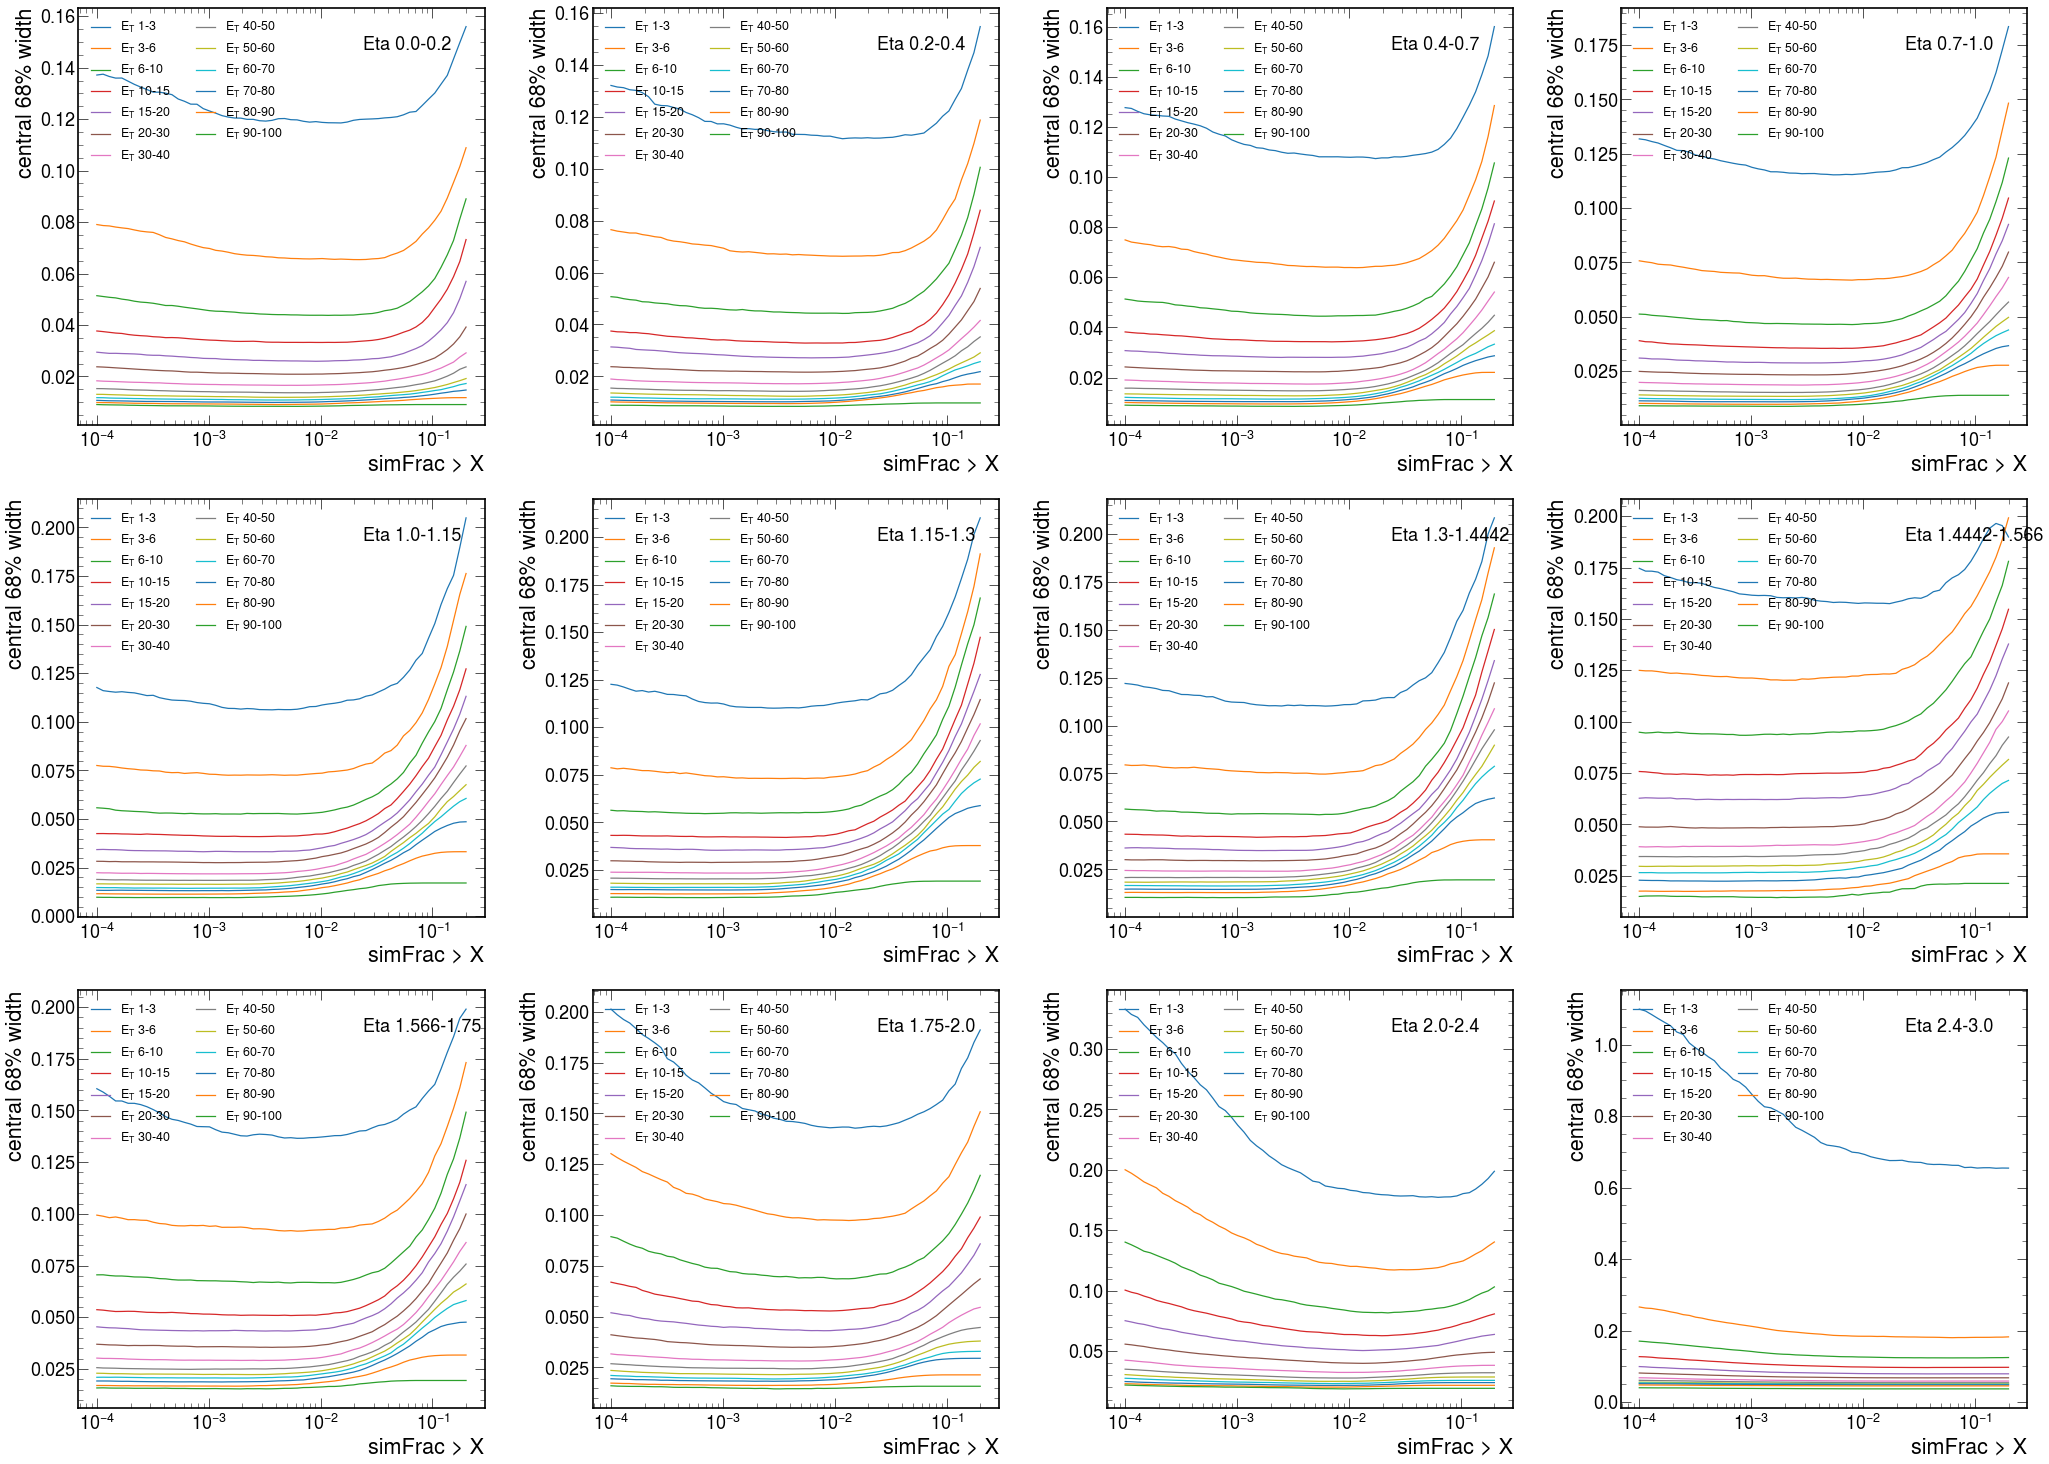

In [32]:
f, axs = plt.subplots(3,4, figsize=(35,25), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.7,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper left', ncol=2)
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("simFrac > X")
#     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

f.tight_layout()
f.savefig(outputdir+'/Width_all.png')
f.savefig(outputdir+'/Width_all.pdf')

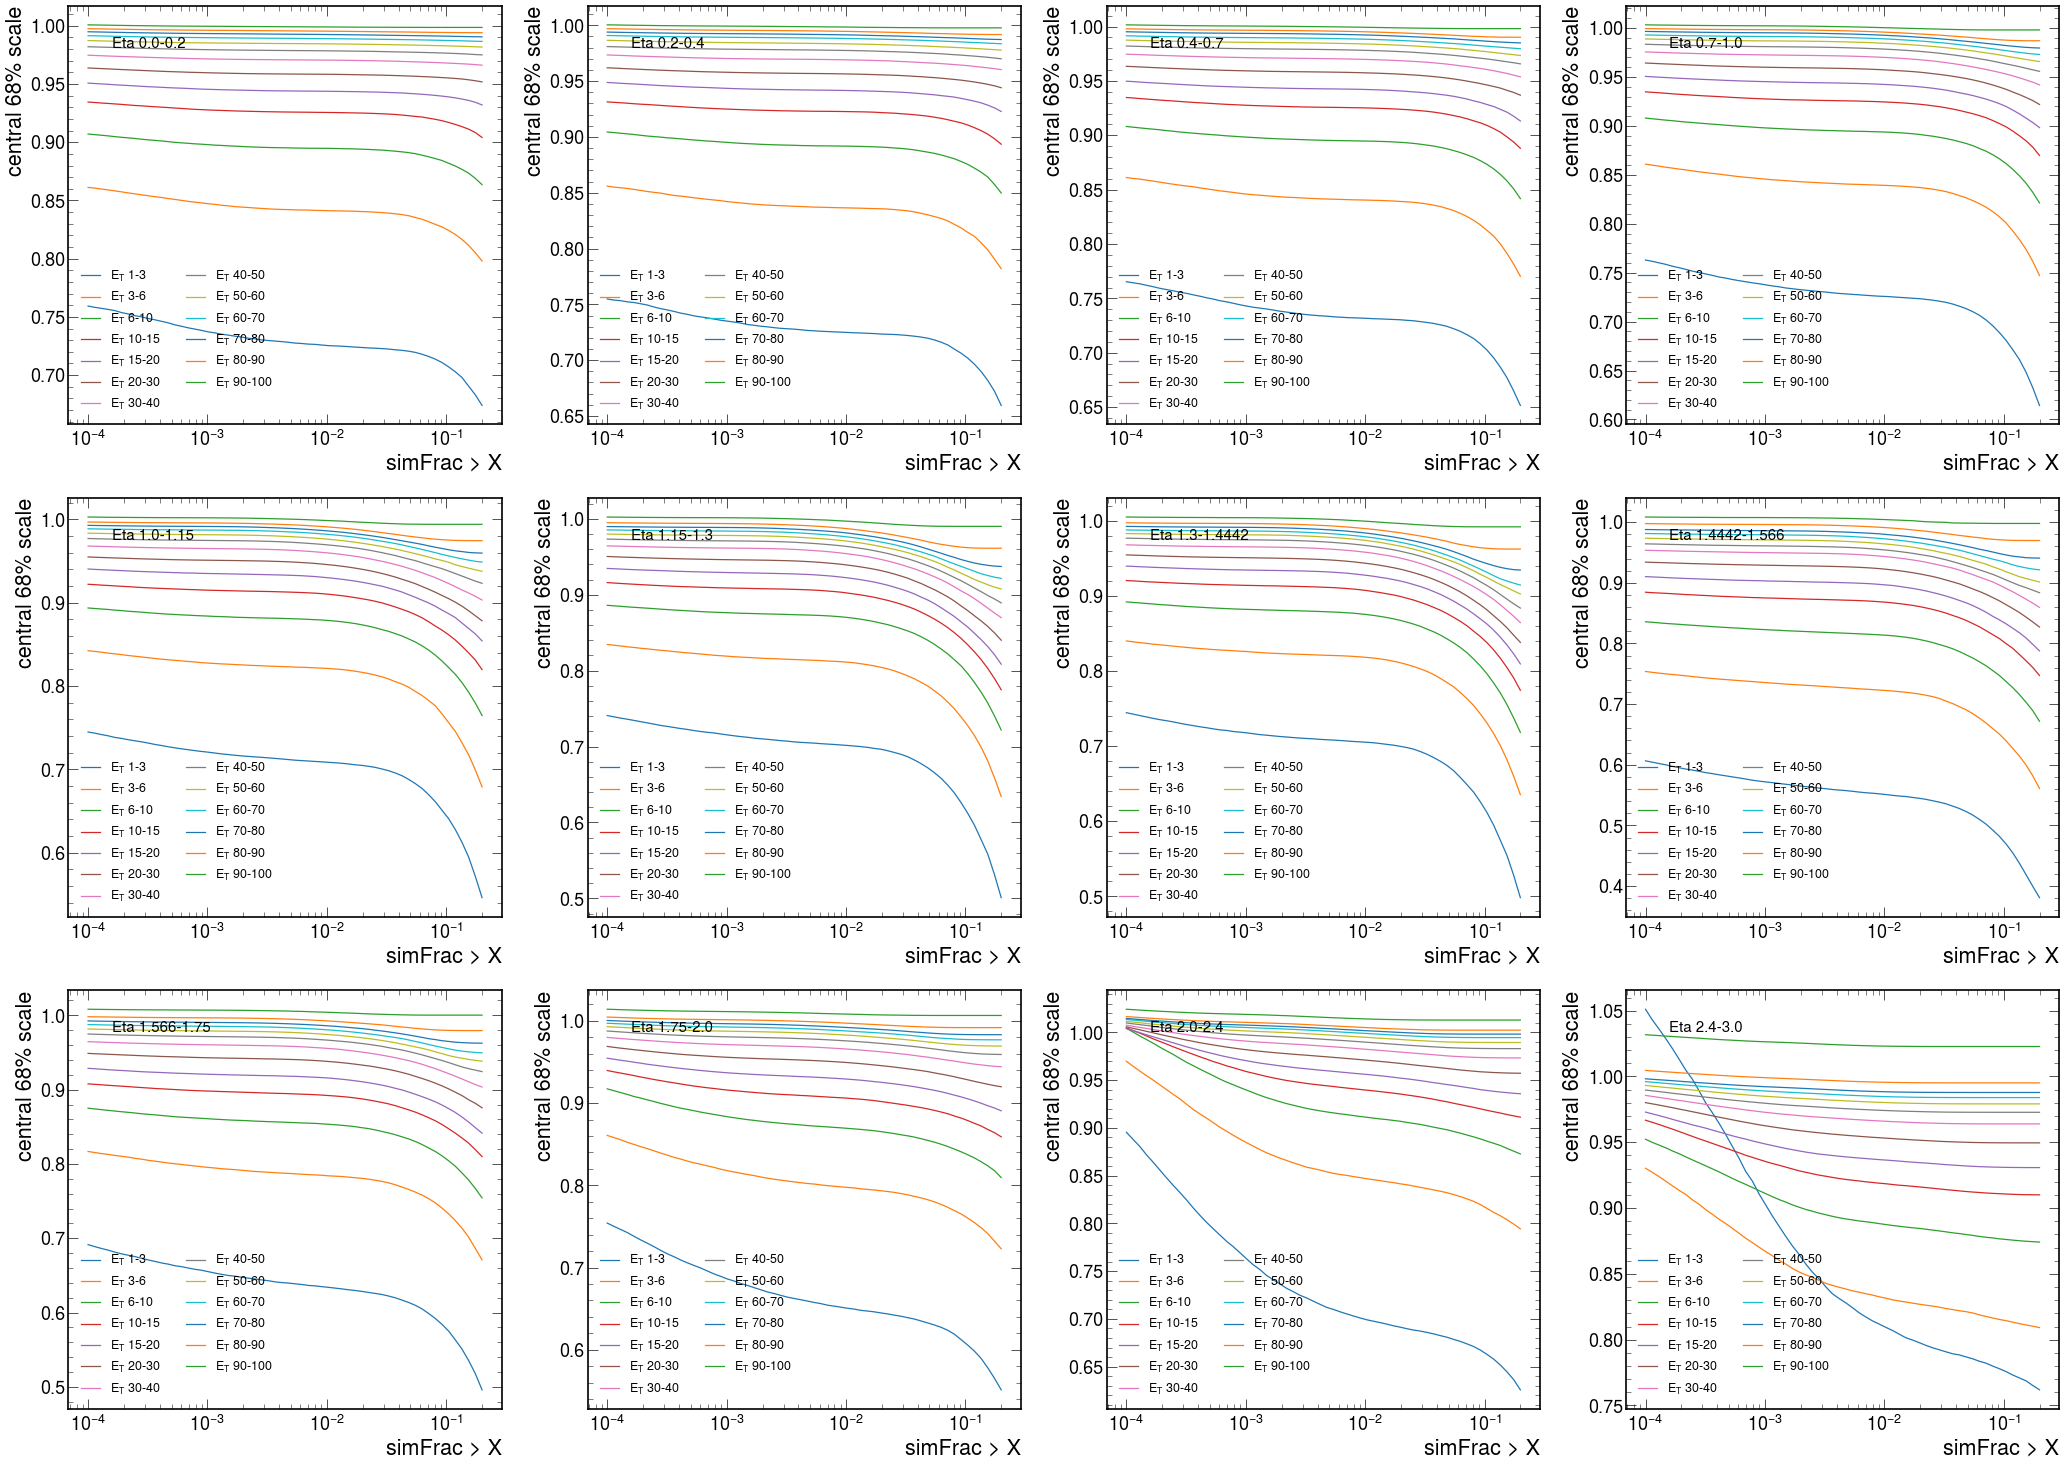

In [33]:
f, axs = plt.subplots(3,4, figsize=(35,25), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68scale, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.1,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='lower left', ncol=2)
    ax.set_ylabel("central 68% scale")
    ax.set_xlabel("simFrac > X")
#     ax.set_xlim(0.001, 0.05)
    ax.set_xscale("log")

f.tight_layout()
f.savefig(outputdir+'/Scale_all.png')

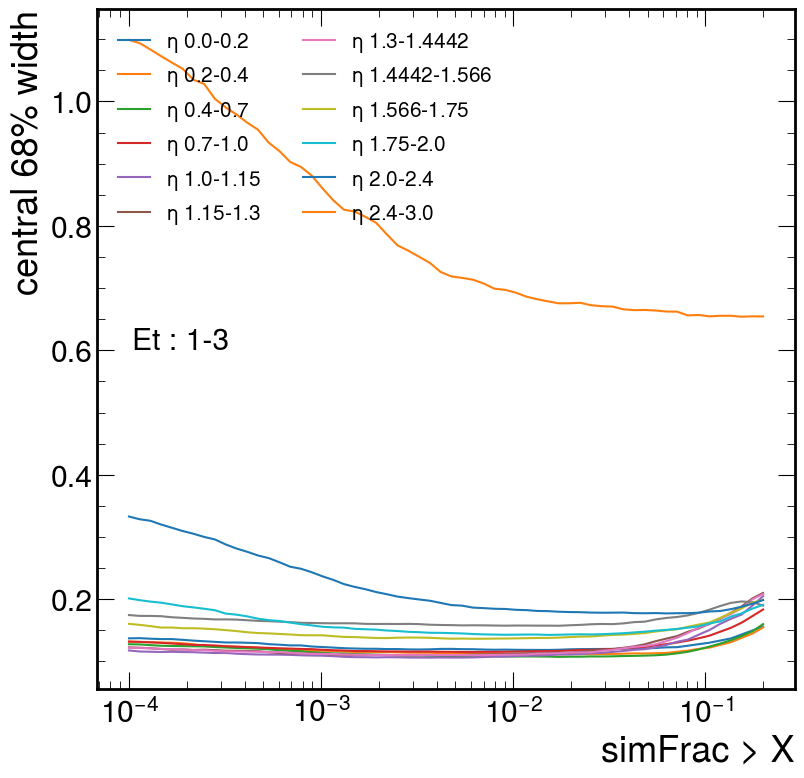

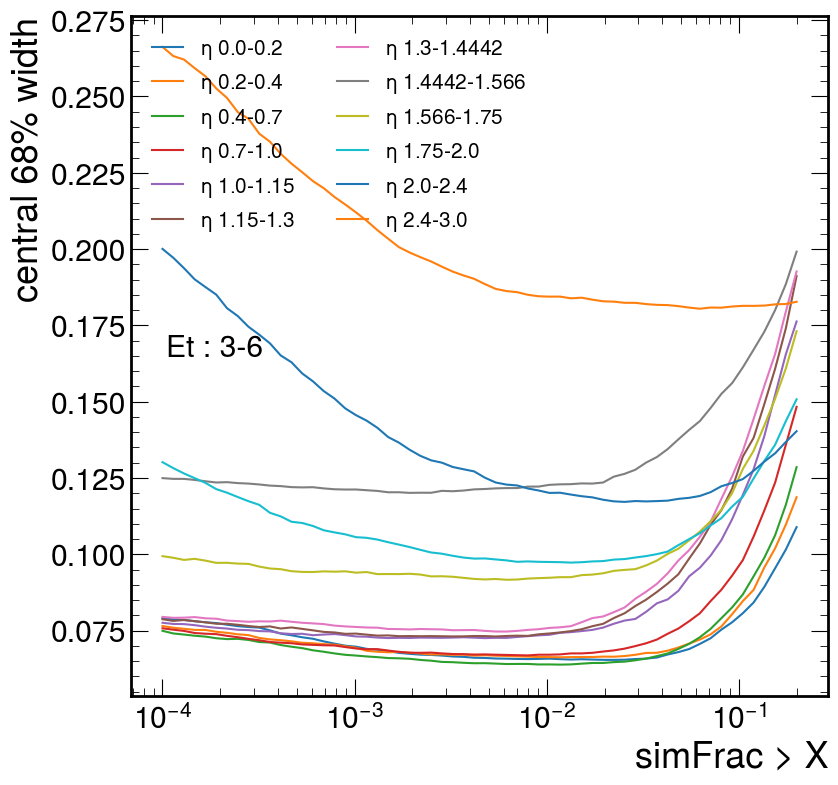

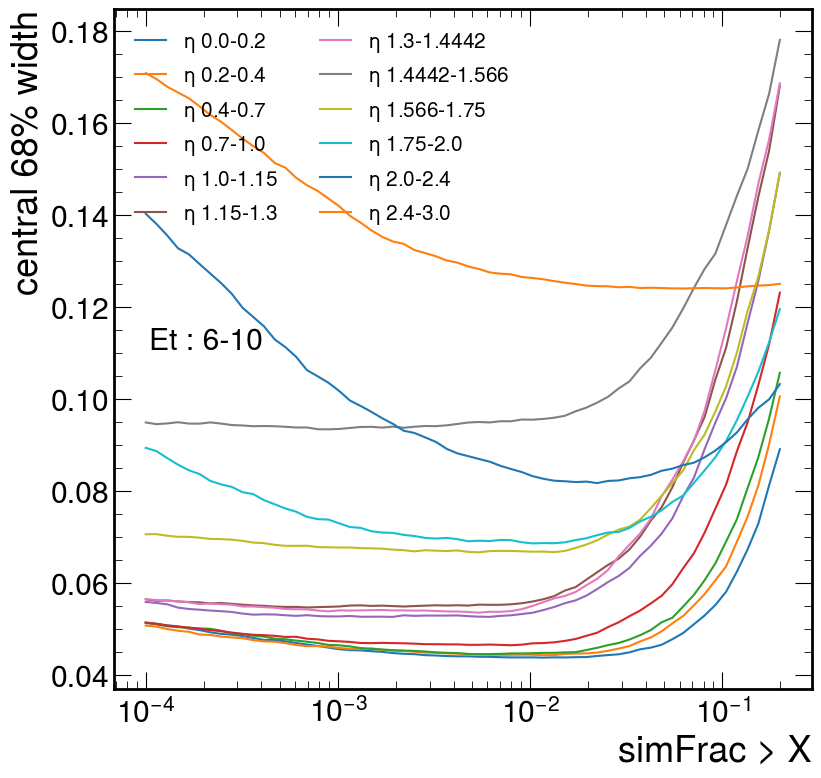

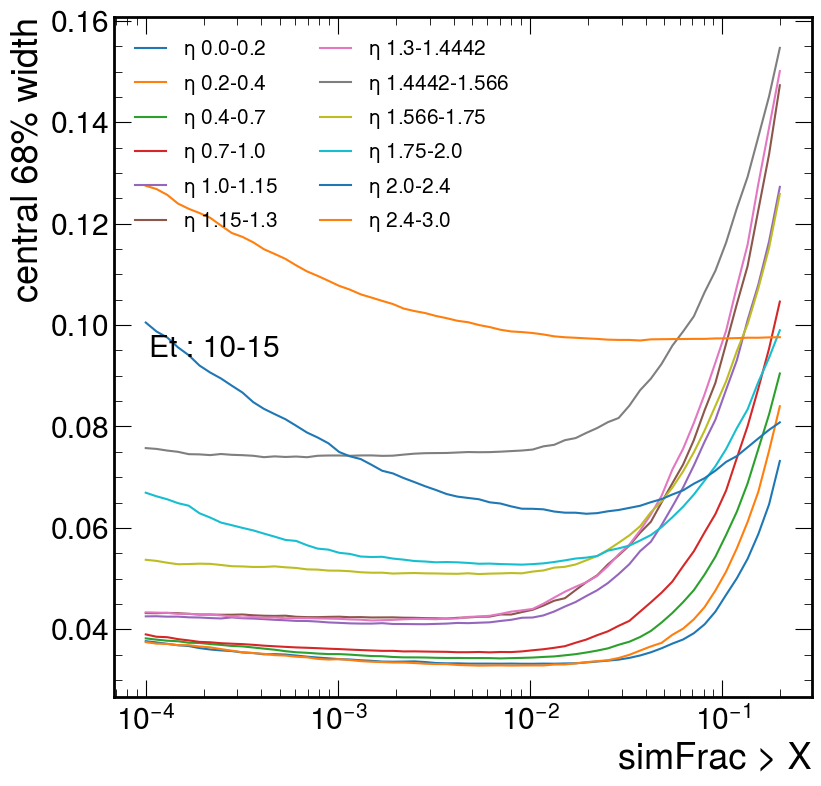

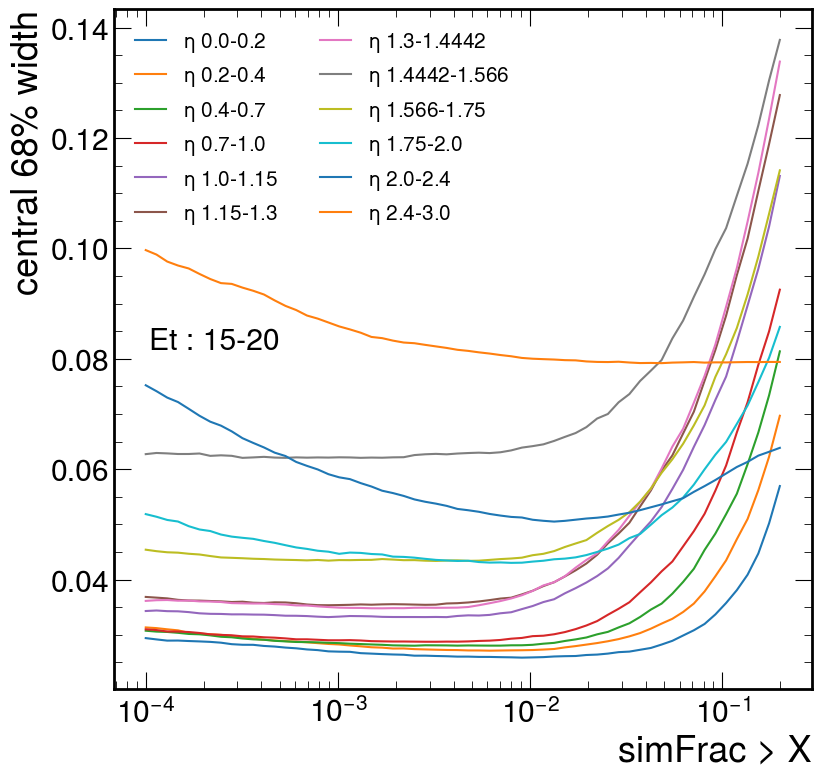

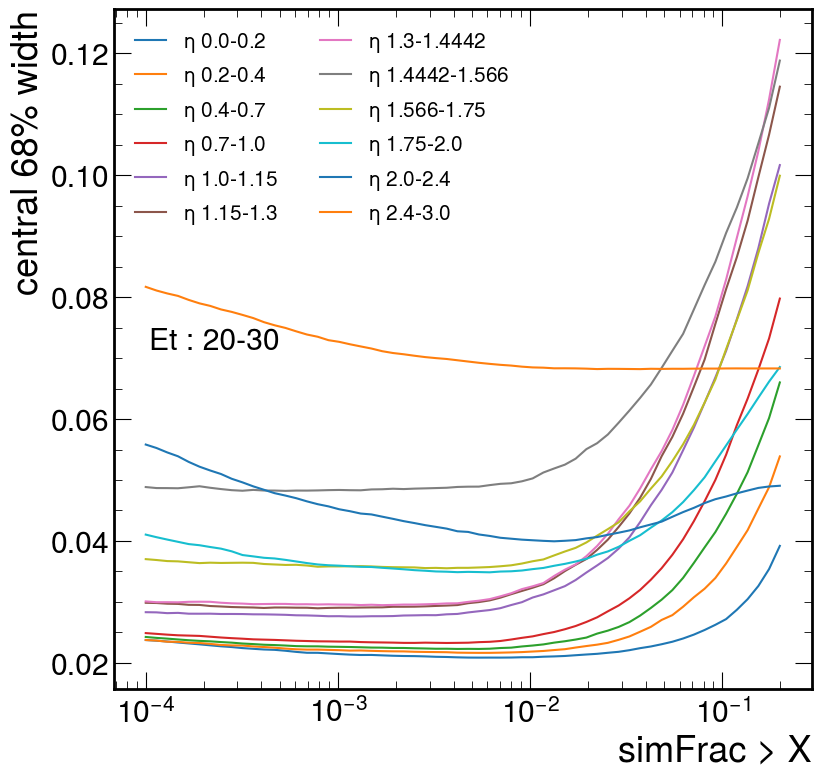

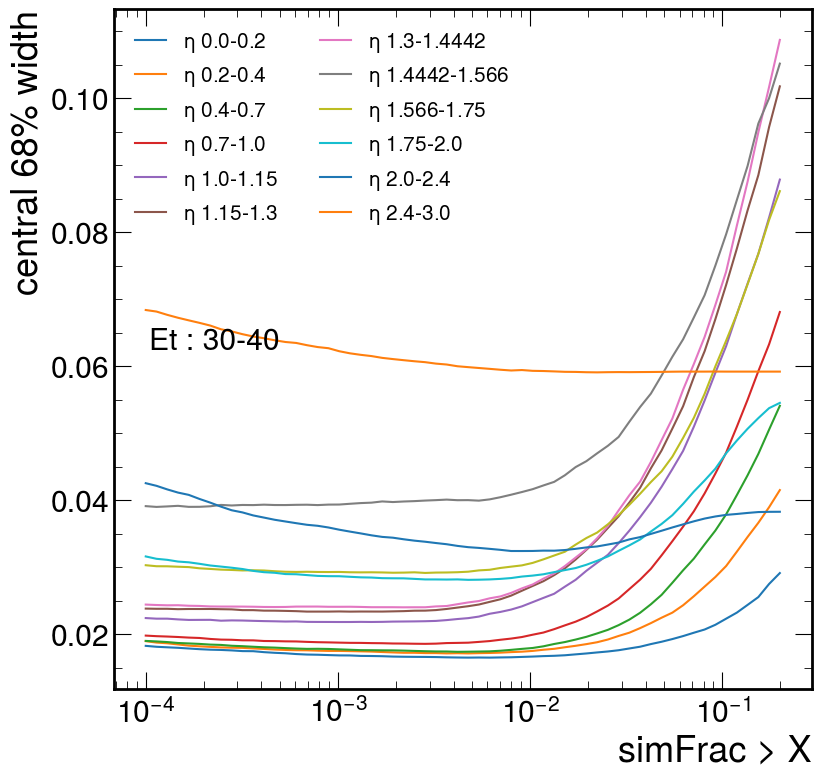

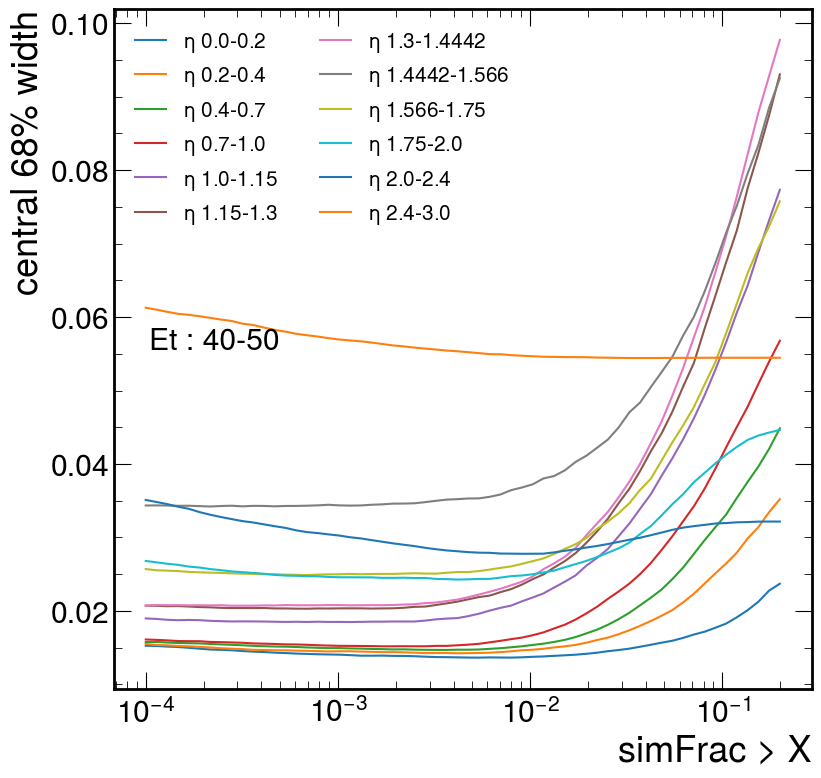

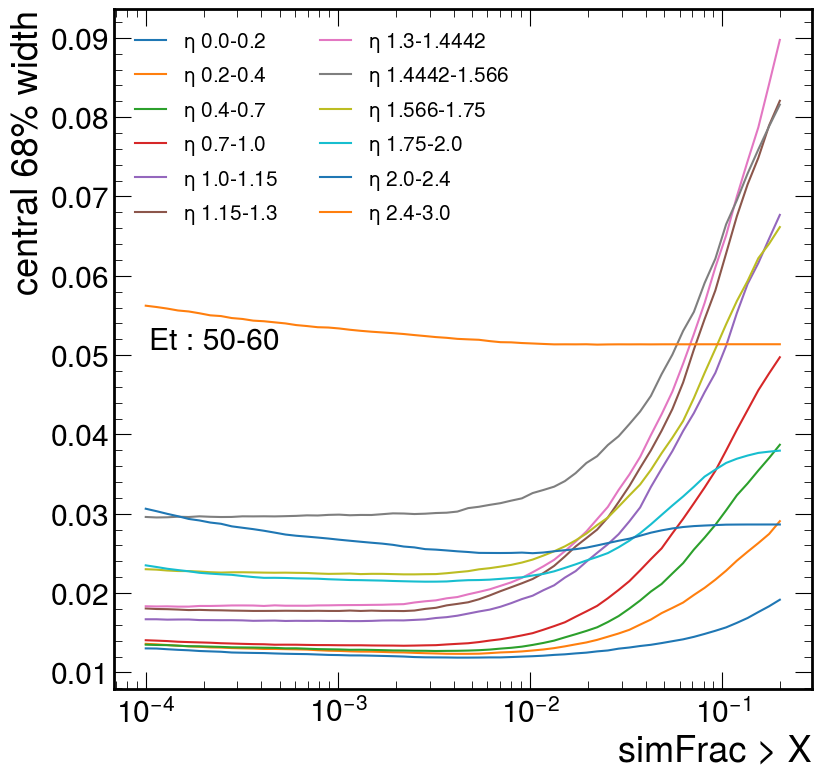

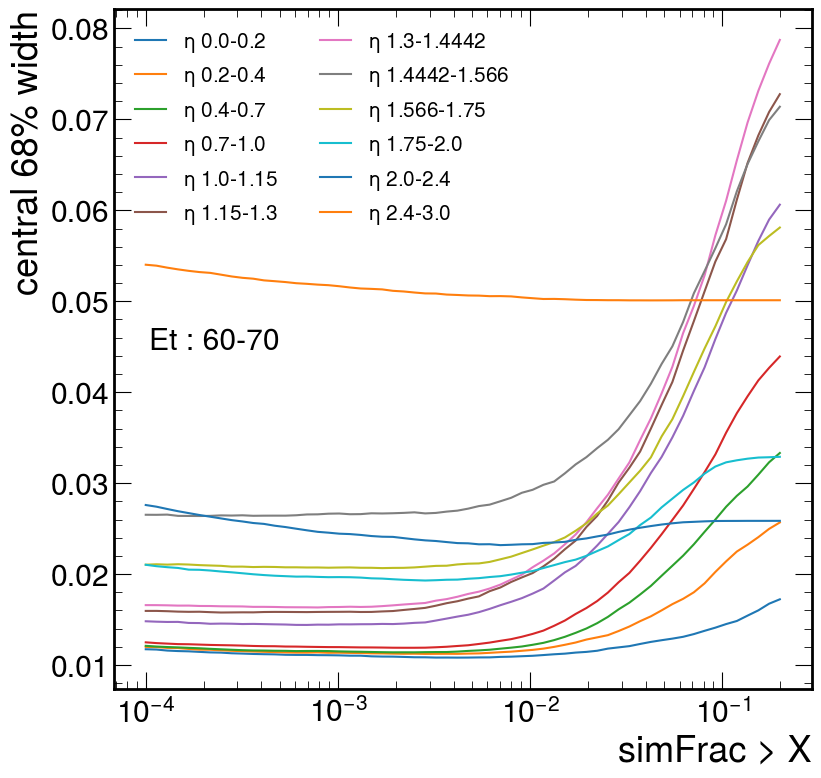

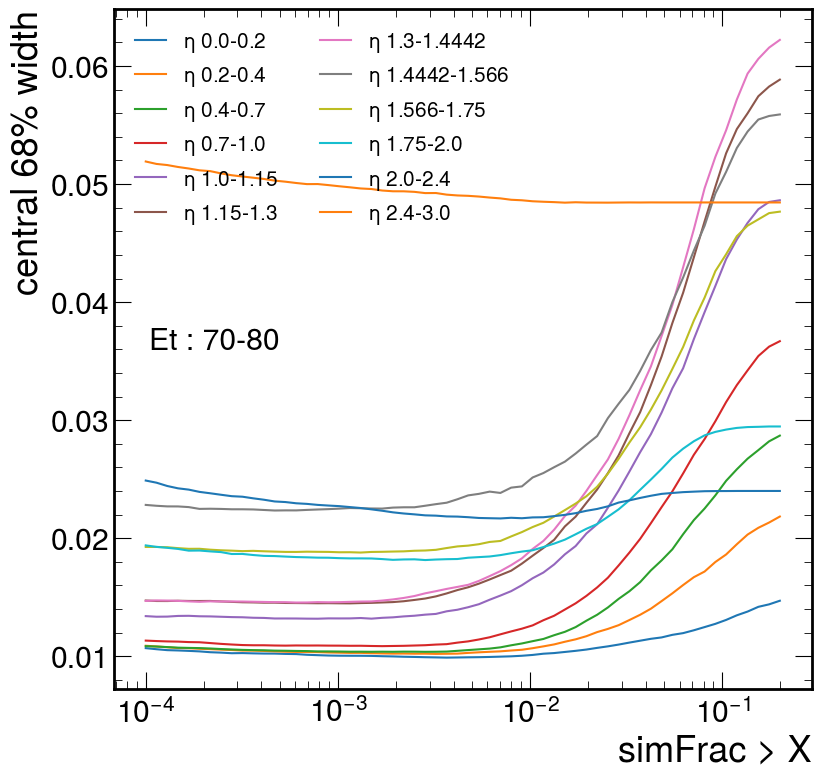

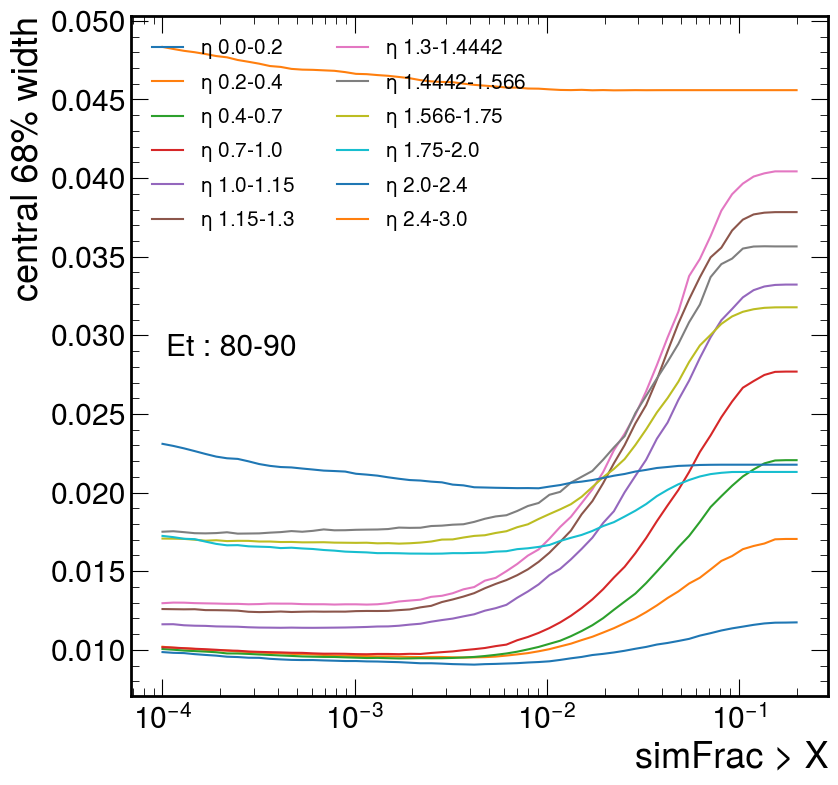

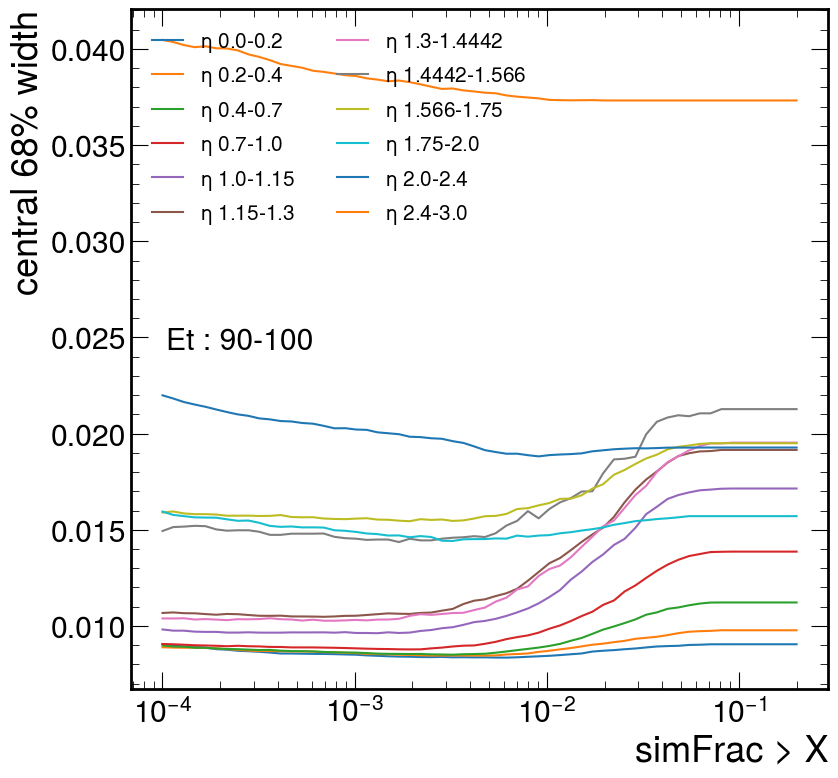

In [34]:
for iet in range(len(ets)-1):
    f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

    for i in range(len(etas)-1): 
        a = res[(res.eta_bin == i) & (res.et_bin==iet)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]))

    ax.text(0.05,0.5, "Et : {}-{}".format(ets[iet],ets[iet+1]),fontsize="small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper left', ncol=2)
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("simFrac > X")
    #     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

    f.savefig(outputdir+'/Width_Et{}_{}.png'.format(ets[iet],ets[iet+1]))
    f.savefig(outputdir+'/Width_Et{}_{}.pdf'.format(ets[iet],ets[iet+1]))

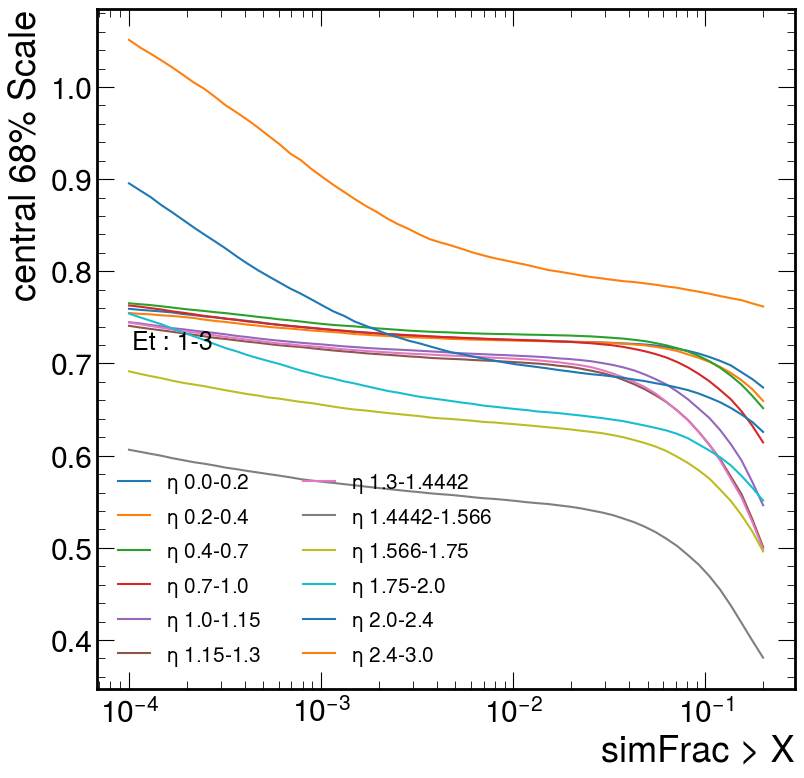

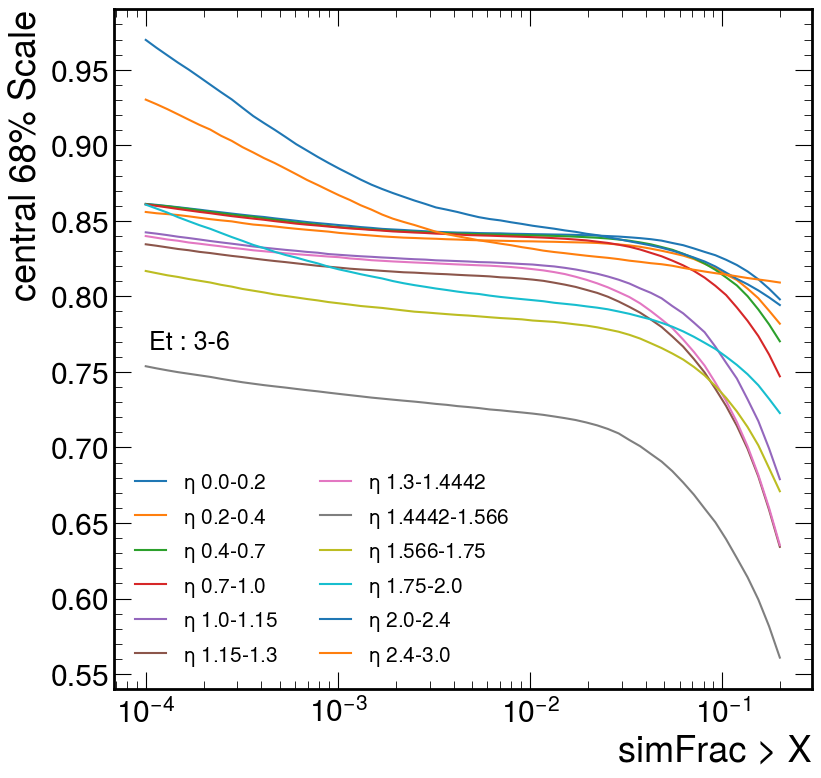

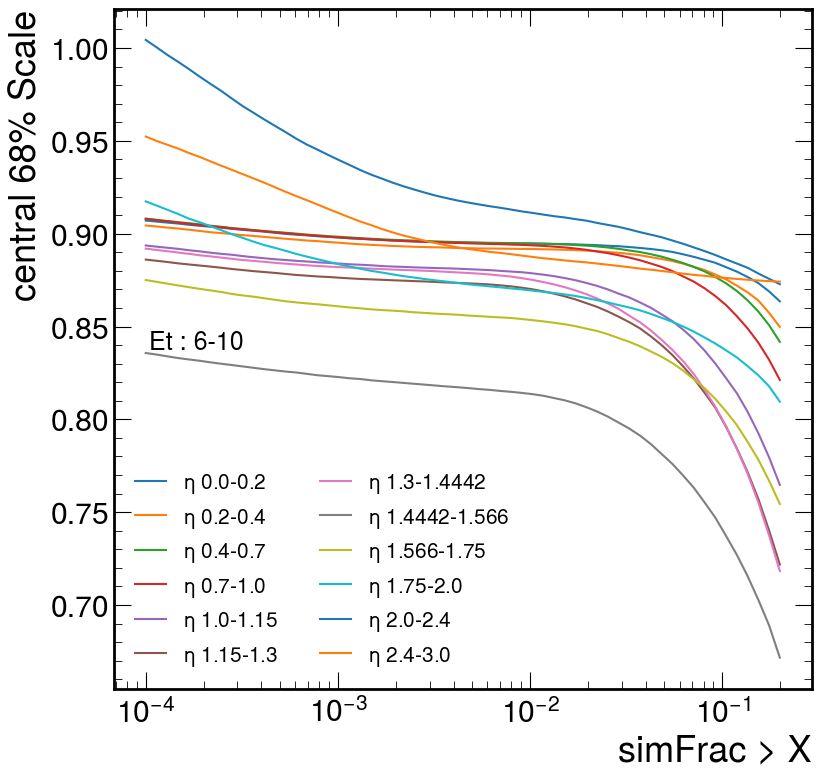

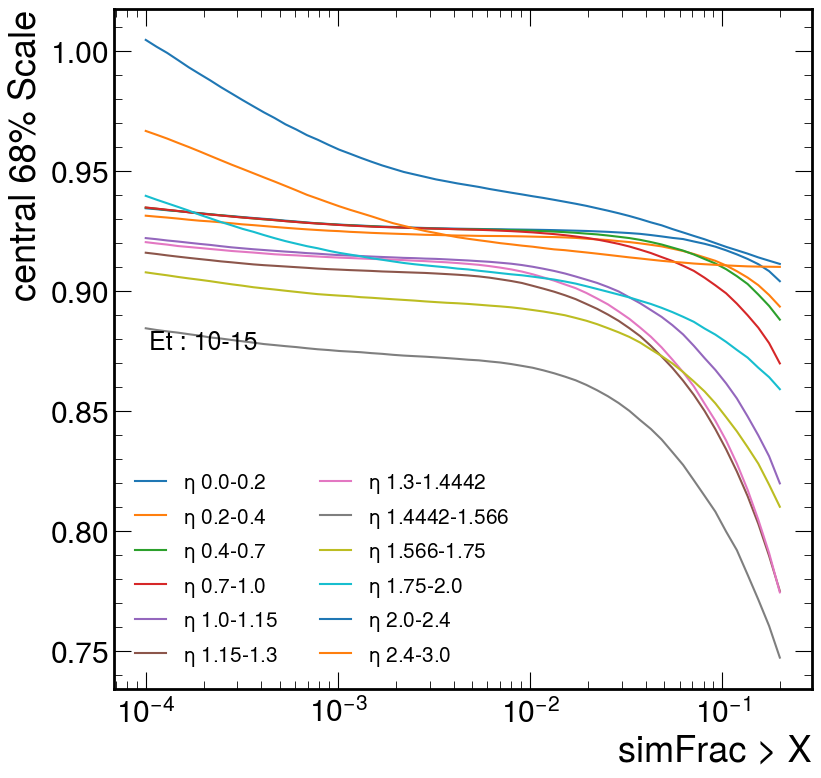

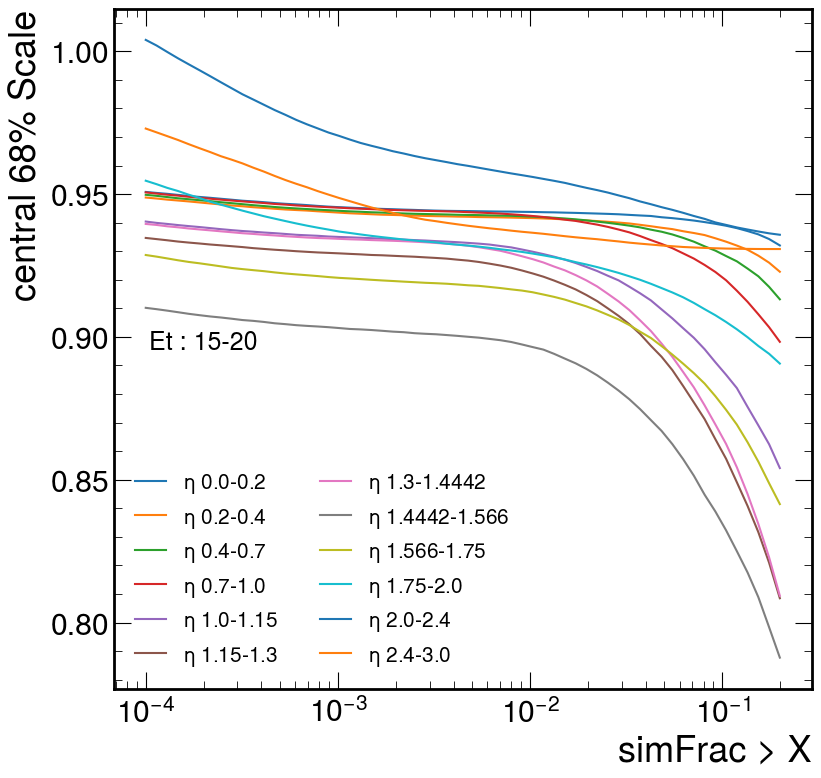

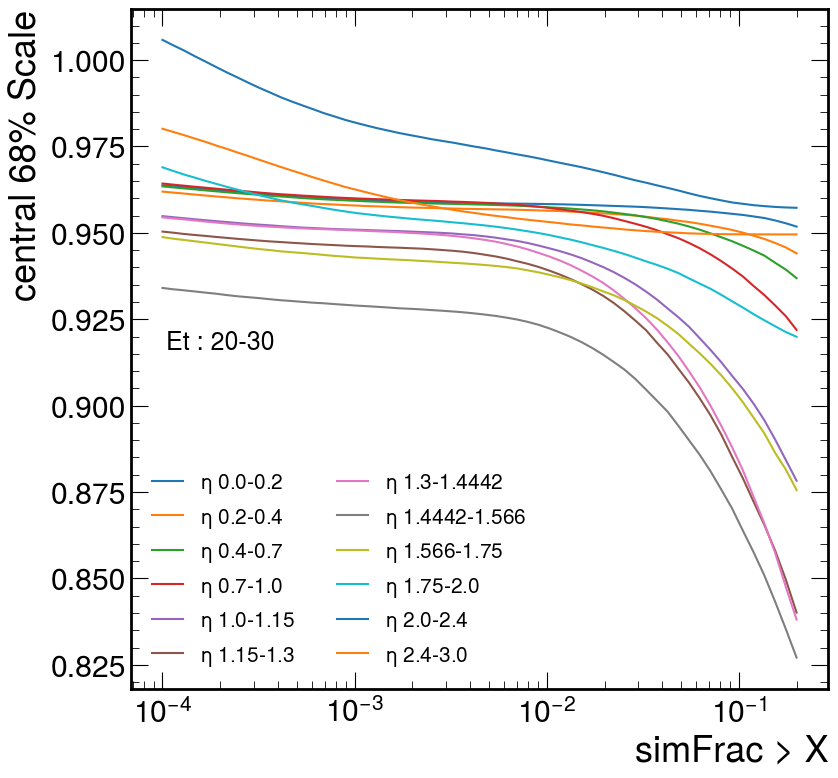

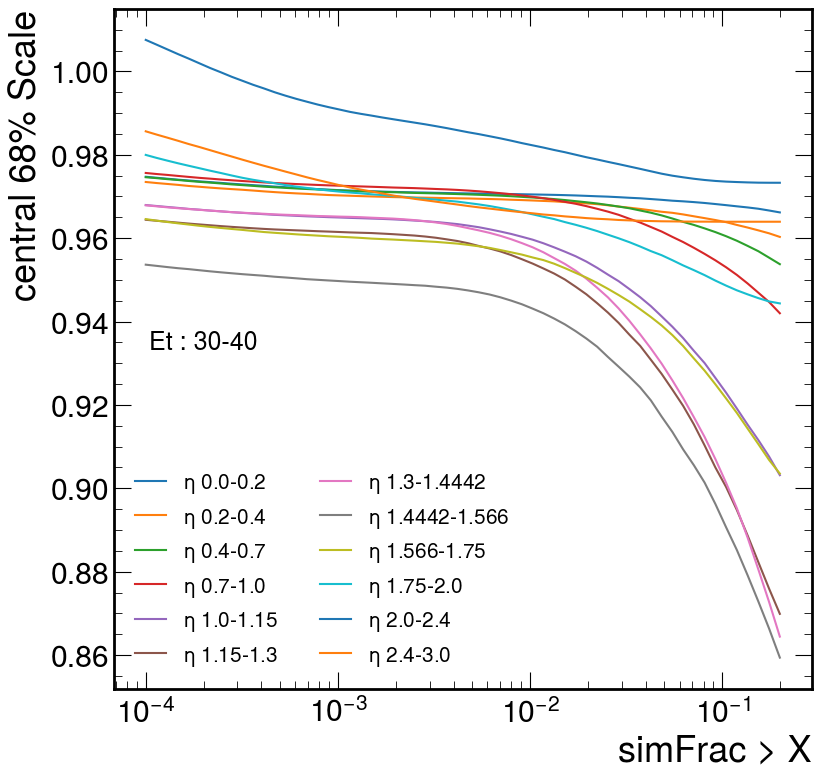

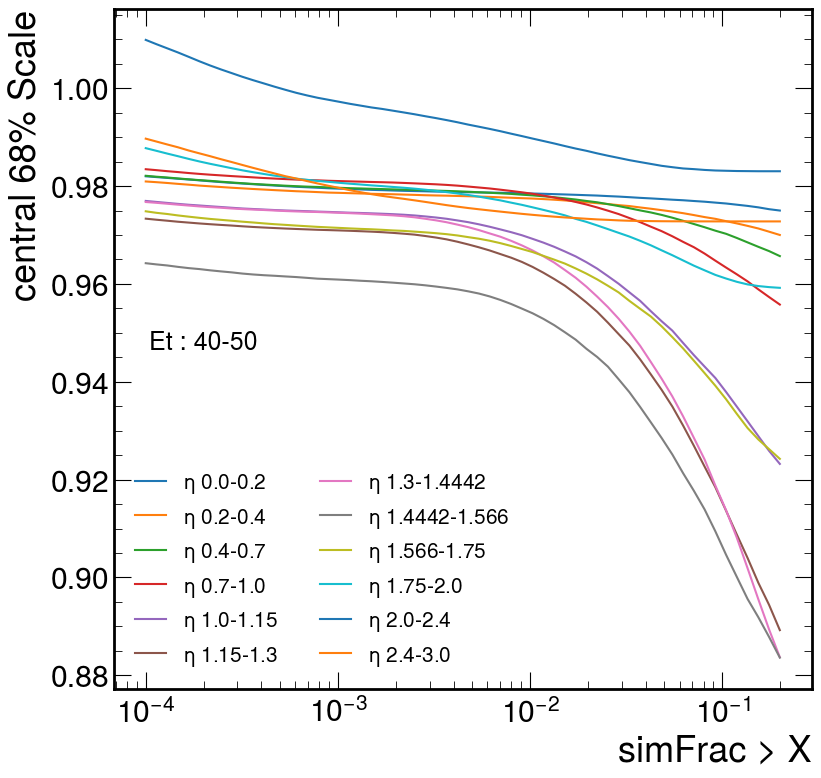

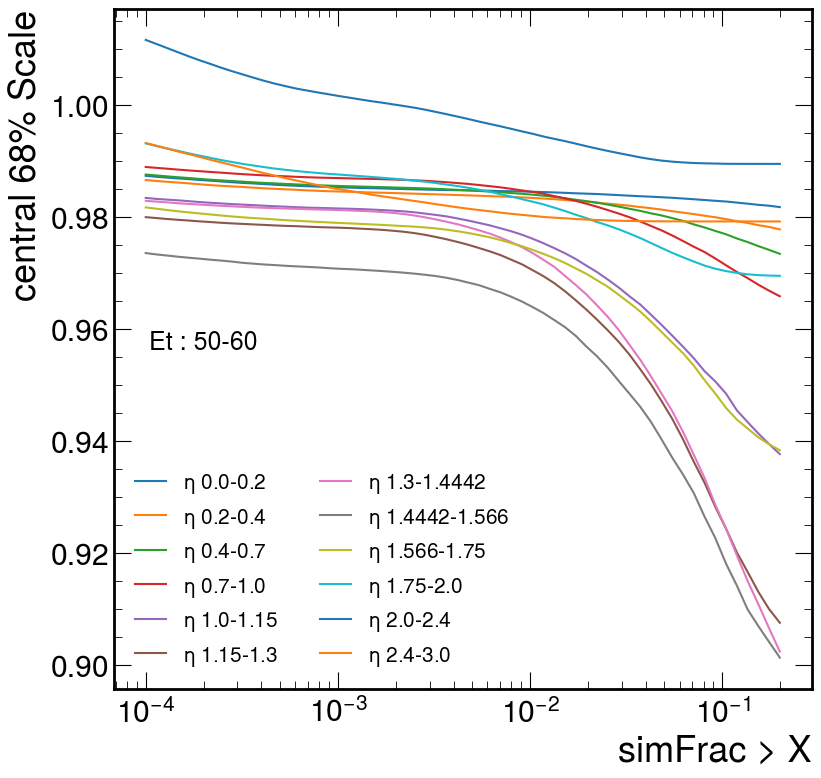

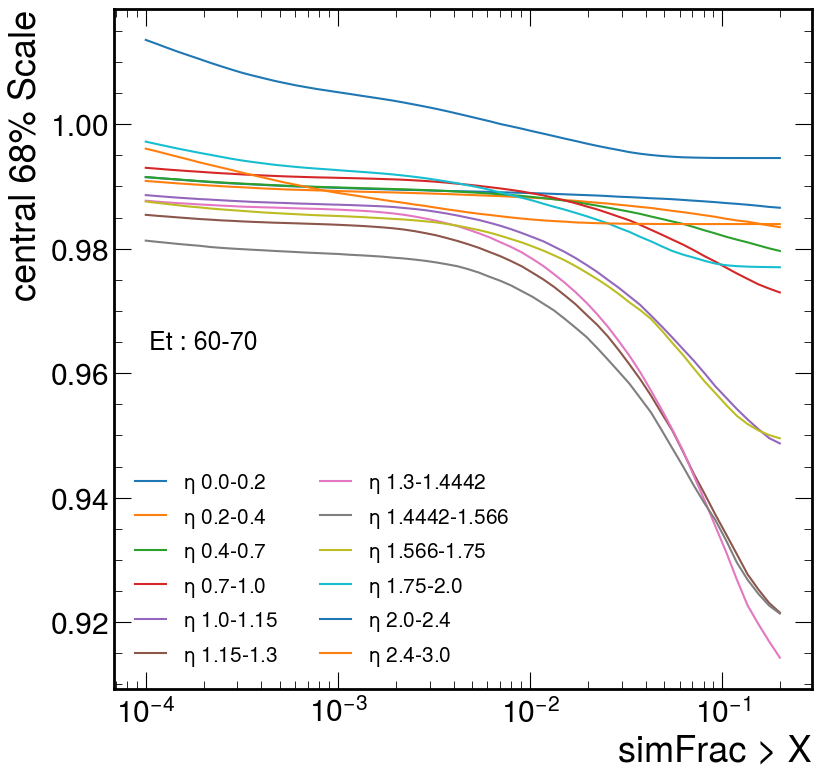

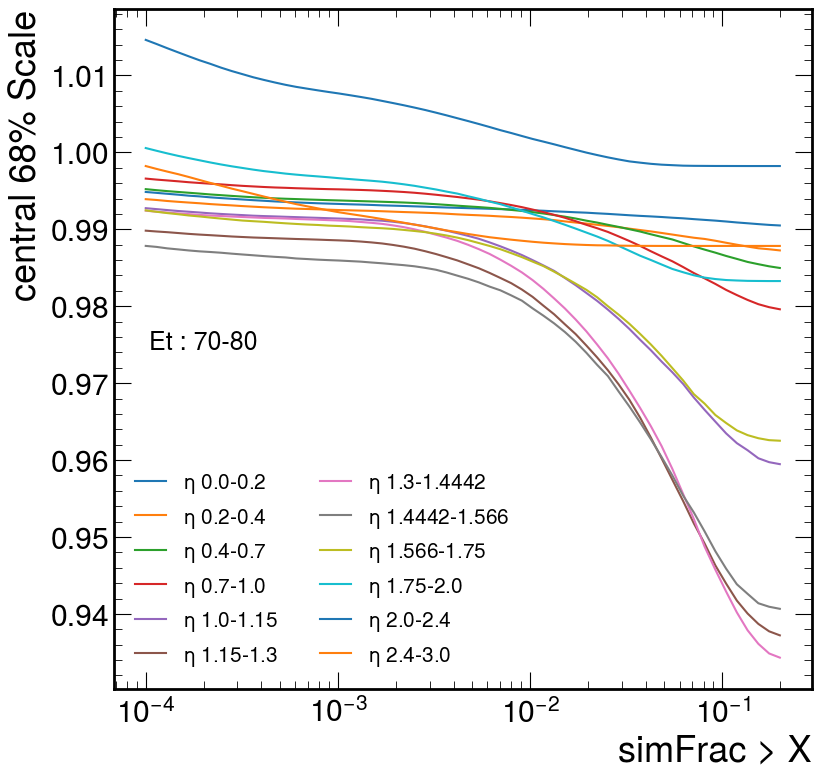

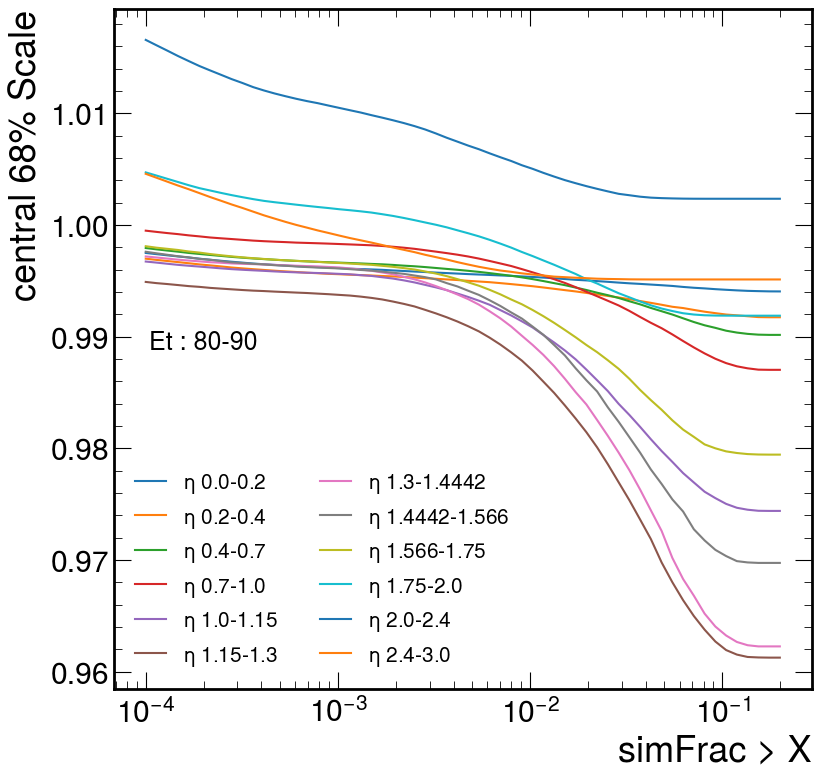

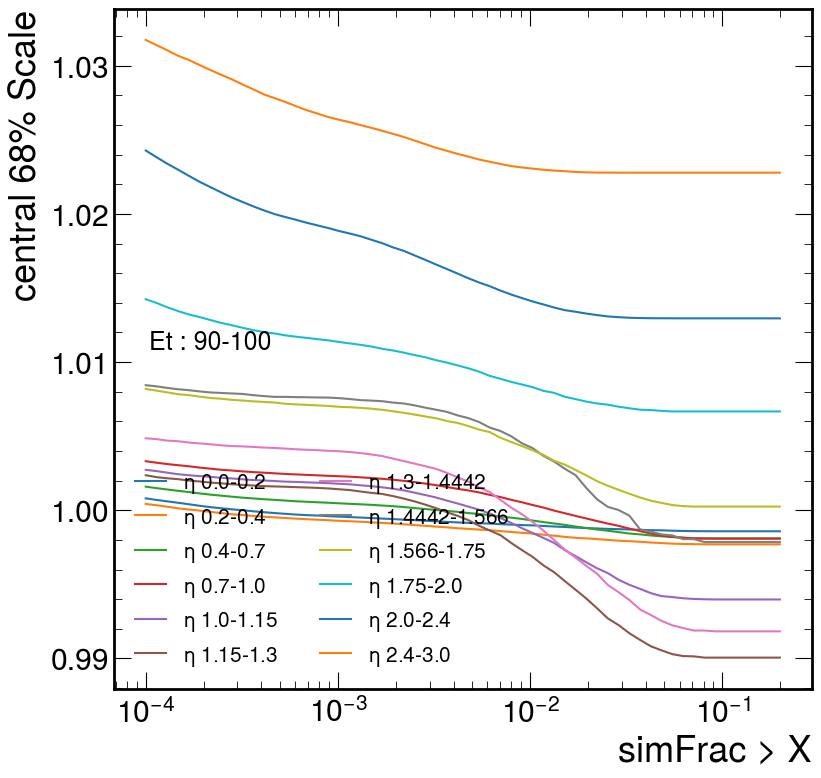

In [35]:
for iet in range(len(ets)-1):
    f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

    for i in range(len(etas)-1): 
        a = res[(res.eta_bin == i) & (res.et_bin==iet)]
        ax.plot(a.thr, a.EoEtrue_68scale, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]))

    ax.text(0.05,0.5, "Et : {}-{}".format(ets[iet],ets[iet+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='lower left', ncol=2)
    ax.set_ylabel("central 68% Scale")
    ax.set_xlabel("simFrac > X")
    #     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

    f.savefig(outputdir+'/Scale_{}_{}.png'.format(ets[iet],ets[iet+1]))
    f.savefig(outputdir+'/Scale_{}_{}.pdf'.format(ets[iet],ets[iet+1]))

# Summary thresholds
Now we check which threshold corresponds to the best truth resolution in each eta/pt bin

In [36]:
def bin_analysis_summary(df):
    line = df.iloc[df["EoEtrue_68width"].argmin()]
    return pd.Series({
        "thr": line['thr'],
        "scale": line["EoEtrue_68width"],
        "width": line["EoEtrue_68width"],
        "rel_err" : line["rel_err"]
    })

a = res.groupby(['et_bin','eta_bin']).apply(bin_analysis_summary)
a.reset_index(level=0, inplace=True)
a.reset_index(level=0, inplace=True)

In [37]:
simfrac_thr = a
simfrac_thr.to_csv(outputdir+ "/best_resolution_simfrac_threshold.csv", sep=";", index=False)

In [5]:
#loading
simfrac_thr = pd.read_csv(outputdir+ "/best_resolution_simfrac_threshold.csv", sep=";")

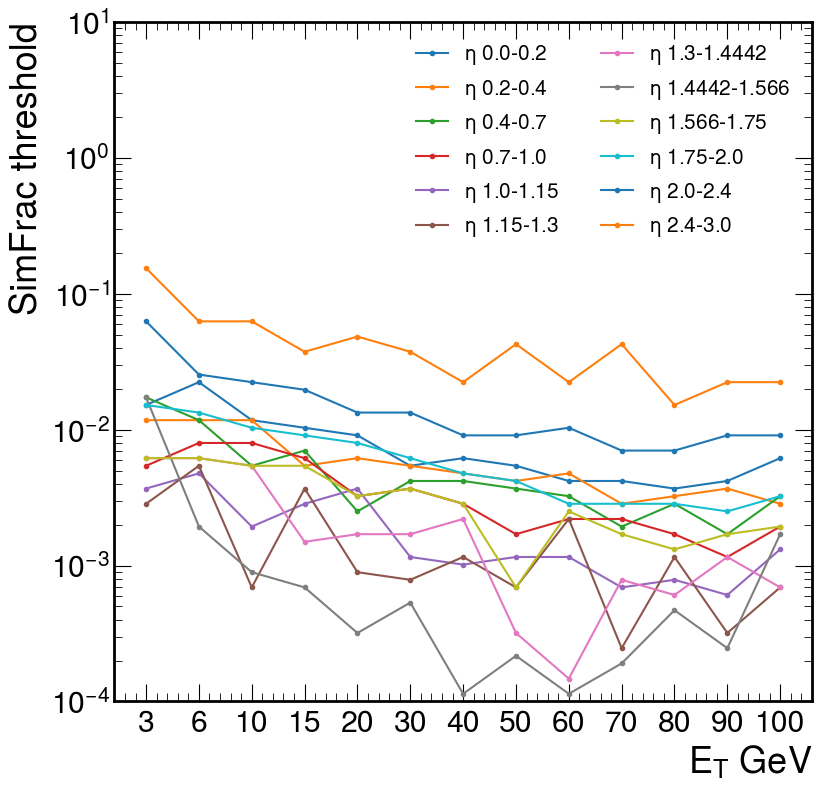

In [39]:
f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

for i in range(len(etas)-1): 
    b = a[a.eta_bin == i]
    ax.plot(b.et_bin, b.thr, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]), marker=".")

ax.legend(fontsize="xx-small", loc='upper right', ncol=2)
ax.set_ylabel("SimFrac threshold")
ax.set_xlabel("$E_T$ GeV")
ax.set_ylim(1e-4, 10)
ax.set_yscale("log")
ax.set_xticks(list(range(len(ets)-1)))
ax.set_xticklabels(["{}".format(et) for et in ets[1:]])

f.savefig(outputdir+'/Scale_all_min.png')

/tmp/ipykernel_1113/684440603.py:3: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(c.T, cmap="plasma", norm=LogNorm(vmin=1e-4, vmax=0.06), origin="lower", vmin=1e-4)


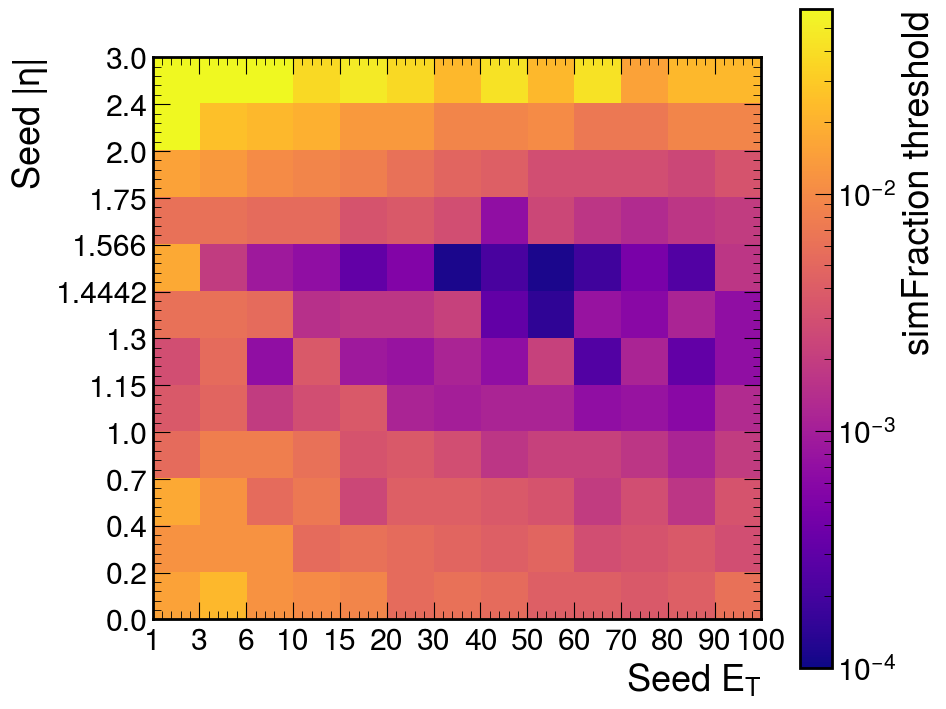

In [44]:
f = plt.figure(figsize=(10,8), dpi=100)
c = a.thr.values.reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", norm=LogNorm(vmin=1e-4, vmax=0.06), origin="lower", vmin=1e-4)
plt.colorbar(label="simFraction threshold")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets])
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map.png")
f.savefig(outputdir+ "/simfraction_map.pdf")

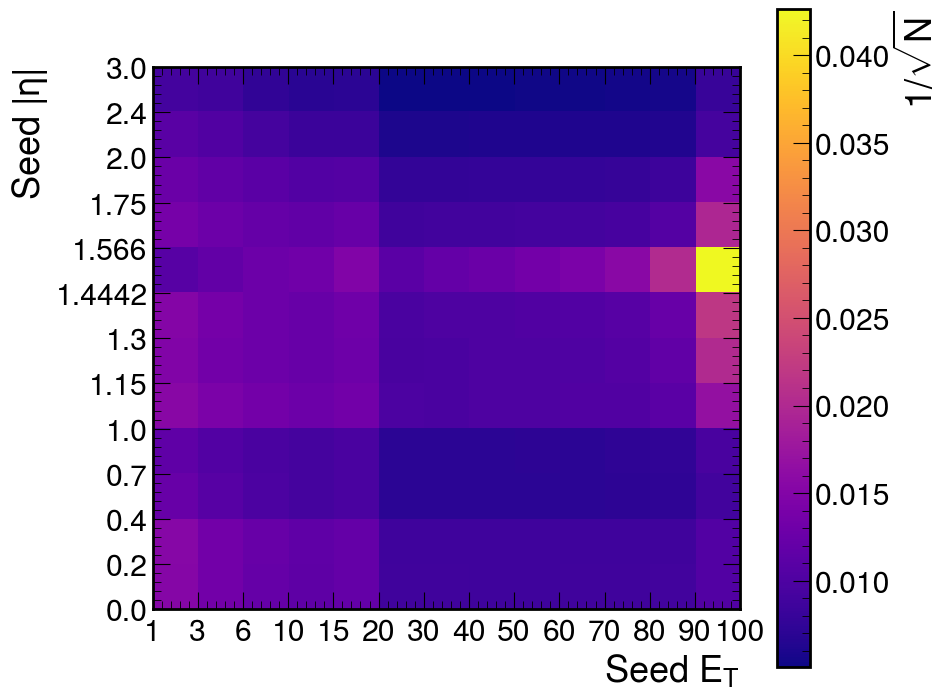

In [41]:
f = plt.figure(figsize=(10,8), dpi=100)
c = a.rel_err.values.reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", origin="lower")
plt.colorbar(label="$1 / \sqrt{N}$")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets])
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map_relerr.png")

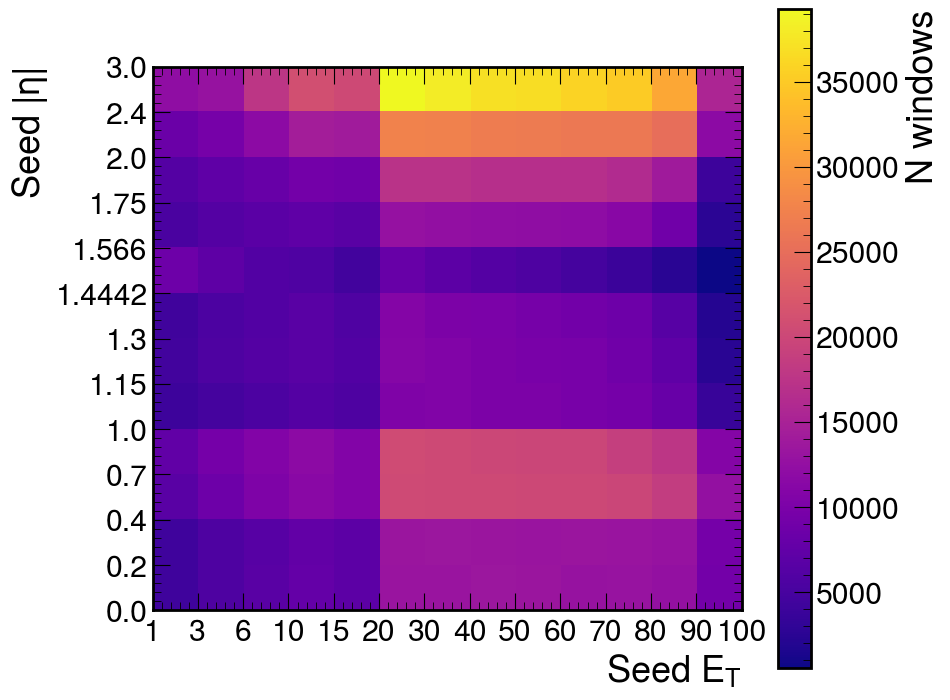

In [42]:
f = plt.figure(figsize=(10,8), dpi=100)
c = np.square((1/ a.rel_err).values).reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", origin="lower")
plt.colorbar(label="N windows")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets])
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map_Nwindows.png")

### Save thresholds to correctionlib

In [6]:
import correctionlib, rich
import correctionlib.convert
import hist

In [7]:
simfrac_thr

eta_bin  et_bin       thr     scale     width   rel_err
0          0       0  0.015183  0.118530  0.118530  0.015259
1          1       0  0.011735  0.111528  0.111528  0.015356
2          2       0  0.017270  0.107379  0.107379  0.012293
3          3       0  0.005419  0.115327  0.115327  0.011639
4          4       0  0.003682  0.106188  0.106188  0.015475
..       ...     ...       ...       ...       ...       ...
151        7      12  0.001700  0.014361  0.014361  0.042640
152        8      12  0.001934  0.015444  0.015444  0.019630
153        9      12  0.003237  0.014417  0.014417  0.015675
154       10      12  0.009070  0.018816  0.018816  0.009193
155       11      12  0.022344  0.037321  0.037321  0.008037

[156 rows x 6 columns]

In [12]:
# 2D array with shapoe et_bin:eta_bin
frac_arr = simfrac_thr["thr"].values.reshape((len(ets)-1, len(etas)-1))
frac_arr.shape

(13, 12)

In [16]:
np.zeros(frac_arr.shape).shape

(13, 12)

In [22]:
h_weight = hist.Hist(
            hist.axis.Variable(ets, name="seed_et"),
            hist.axis.Variable(etas, name="seed_eta"),
            storage="weight",
            data=np.concatenate([frac_arr[:,:,None], np.zeros(frac_arr.shape)[:,:,None]], axis=-1))
h_weight

Hist(
  Variable([1, 3, 6, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100], name='seed_et'),
  Variable([0, 0.2, 0.4, 0.7, 1, 1.15, 1.3, 1.4442, 1.566, 1.75, 2, 2.4, 3], name='seed_eta'),
  storage=Weight()) # Sum: WeightedSum(value=1.34016, variance=0)

In [27]:
 # Exporting it to correctionlib

# without a name, the resulting object will fail validation
h_weight.name = "simfraction_threshold_electron"
h_weight.label = "weight"
clibcorr = correctionlib.convert.from_histogram(h_weight)
clibcorr.description = "SimFractions thresholds for true matching in Electrons"

# set overflow bins behavior (default is to raise an error when out of bounds)
#
cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description="SimFractions thresholds for true matching in Electrons",
    corrections=[clibcorr],
)
rich.print(cset)

with open(f"{outputdir}/simfraction_thresholds_electron.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))


CorrectionSet (schema v2)
SimFractions thresholds for true matching in Electrons
📂
└── 📈 simfraction_threshold_electron (v0)
    SimFractions thresholds for true matching in Electrons
    Node counts: MultiBinning: 1
    ╭────── ▶ input ──────╮ ╭───── ▶ input ─────╮
    │ seed_et (real)      │ │ seed_eta (real)   │
    │ seed_et             │ │ seed_eta          │
    │ Range: [1.0, 100.0) │ │ Range: [0.0, 3.0) │
    ╰─────────────────────╯ ╰───────────────────╯
    ╭─── ◀ output ───╮
    │ weight (real)  │
    │ No description │
    ╰────────────────╯

# Save histogram

Welcome to JupyROOT 6.24/06


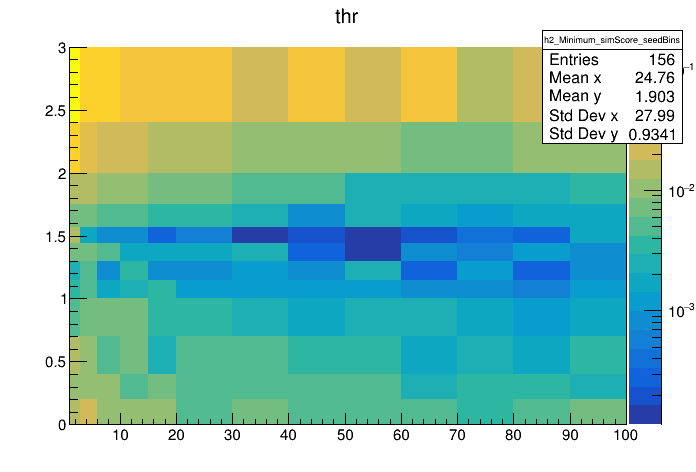

In [43]:
import ROOT as R
from array import array

h2 = R.TH2F("h2_Minimum_simScore_seedBins", "thr", len(ets)-1, array("d", ets), len(etas)-1, array("d", etas))

for _, row in a.iterrows():
    h2.SetBinContent(h2.FindBin(ets[int(row.et_bin)], etas[int(row.eta_bin)]), row.thr)
    
c = R.TCanvas()
h2.Draw("COLZ")
c.SetLogz()
c.Draw()

out = R.TFile(outputdir+"/simScore.root","RECREATE")
h2.Write()
out.Close()

We loop on all the eta and et bins and apply the best threshold. Then we take the maximum dphi and deta from the seed to study the dimension of the window

# Window dimension after simFraction selection 
## Dimension by eta and Et

In [92]:
# Requiring a minimum of 1% of simFraction for the seeds for quality
dfb = dfa[(dfa.seed_simfrac_sig > 0.01)]  # Do now require any geometrical window limit  & (dfa.in_window)
dfb["et_bin"] = pd.cut(dfb["seed_et"], ets, labels=list(range(len(ets)-1)))
dfb["eta_bin"] = pd.cut(dfb["seed_eta"].abs(), etas, labels=list(range(len(etas)-1)))

/tmp/ipykernel_847/1387350978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb["et_bin"] = pd.cut(dfb["seed_et"], ets, labels=list(range(len(ets)-1)))
/tmp/ipykernel_847/1387350978.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb["eta_bin"] = pd.cut(dfb["seed_eta"].abs(), etas, labels=list(range(len(etas)-1)))


In [93]:
results = []
for (iet, ieta), g in  dfb.groupby(["et_bin", "eta_bin"]):
    #print(f"Working on Et:{iet}, Eta:{ieta}")
    thr = simfrac_thr[(simfrac_thr.eta_bin == ieta)&(simfrac_thr.et_bin == iet)].thr
    A =  g[(g.simfrac_sig >  thr.values[0]) | (g.is_seed==1) ].groupby("window_index", sort=False).agg(
                        {
                         "dphi_seed": 'max' ,
                         "deta_seed": "max", 
                    })
    A["ieta"] = ieta
    A["iet"] = iet
    results.append(A)
    
WS = pd.concat(results)

Text(1, 0, 'Max $\\Delta\\phi(cl-seed)$')

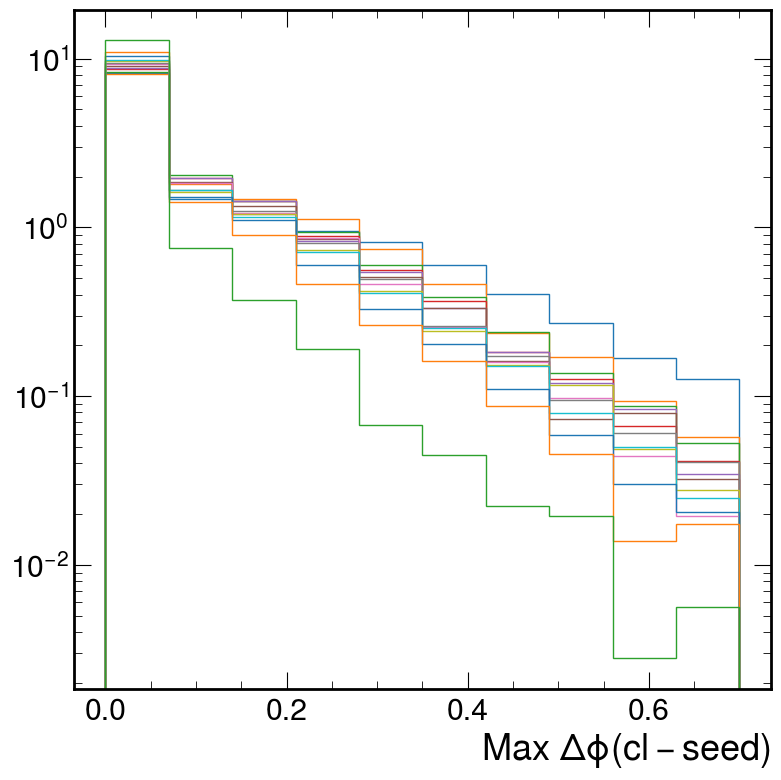

In [95]:
nEt = len(ets)-1
nEta = len(etas)-1
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
iEta = 5
for iEt in range(nEt):
    ax.hist(WS[(WS.iet==iEt)&(WS.ieta==iEta)].dphi_seed, 
             label=f"$\eta$=[{etas[iEta]},{etas[iEta+1]}], $E_T$=[{ets[iEt]},{ets[iEt+1]}]",
             range=(0, 0.7), bins=10, histtype="step", density=True)
ax.set_yscale("log")
ax.set_xlabel("Max $\Delta\phi(cl-seed)$")
#ax.legend()

Text(1, 0, 'Max $\\Delta\\eta(cl-seed)$')

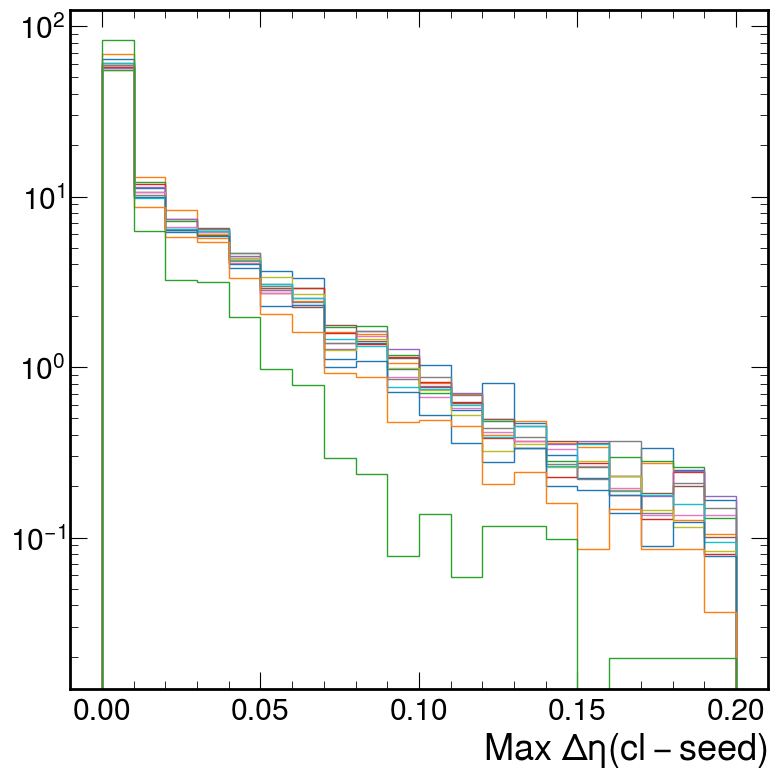

In [96]:
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
iEta = 5
for iEt in range(nEt):
    ax.hist(WS[(WS.iet==iEt)&(WS.ieta==iEta)].deta_seed, 
             label=f"$\eta$=[{etas[iEta]},{etas[iEta+1]}], $E_T$=[{ets[iEt]},{ets[iEt+1]}]",
             range=(0, 0.2), bins=20, histtype="step", density=True)
ax.set_yscale("log")
ax.set_xlabel("Max $\Delta\eta(cl-seed)$")
#ax.legend()

## Only by seed Eta

In [98]:
results = []
for ieta, g in  dfb.groupby("eta_bin"):
    #print(f"Working on Et:{iet}, Eta:{ieta}")
    thr = simfrac_thr[(simfrac_thr.eta_bin == ieta)].thr
    A =  g[(g.simfrac_sig >  thr.values[0]) | (g.is_seed==1) ].groupby("window_index", sort=False).agg(
                        {
                         "dphi_seed": [np.min, np.max],
                         "deta_seed":  [np.min, np.max]
                    })
    A["ieta"] = ieta
    results.append(A)
    
WS_etaonly = pd.concat(results)

In [99]:
WS_etaonly.dphi_seed.amin

window_index
afhojuvx    0.0
wdmeslyv    0.0
glgkbwxr    0.0
cmndinii    0.0
uguqfsjc    0.0
           ... 
rjvtbuak    0.0
mufeffek    0.0
swjpcpxe    0.0
izewslff    0.0
jqzyvjvq    0.0
Name: amin, Length: 1947566, dtype: float64

In [100]:
maxq = 0.995
maxWS_eo = WS_etaonly.groupby('ieta').apply(lambda df: pd.Series(
    {"dphi_min": df.dphi_seed.amin.quantile(1-maxq),
     "dphi_max": df.dphi_seed.amax.quantile(maxq),
     "deta_min": df.deta_seed.amin.quantile(1-maxq),
     "deta_max": df.deta_seed.amax.quantile(maxq)}))

maxWS_eo.reset_index(level=0, inplace=True)
maxWS_eo.reset_index(level=0, inplace=True)

Text(0, 1, '$\\Delta\\phi$')

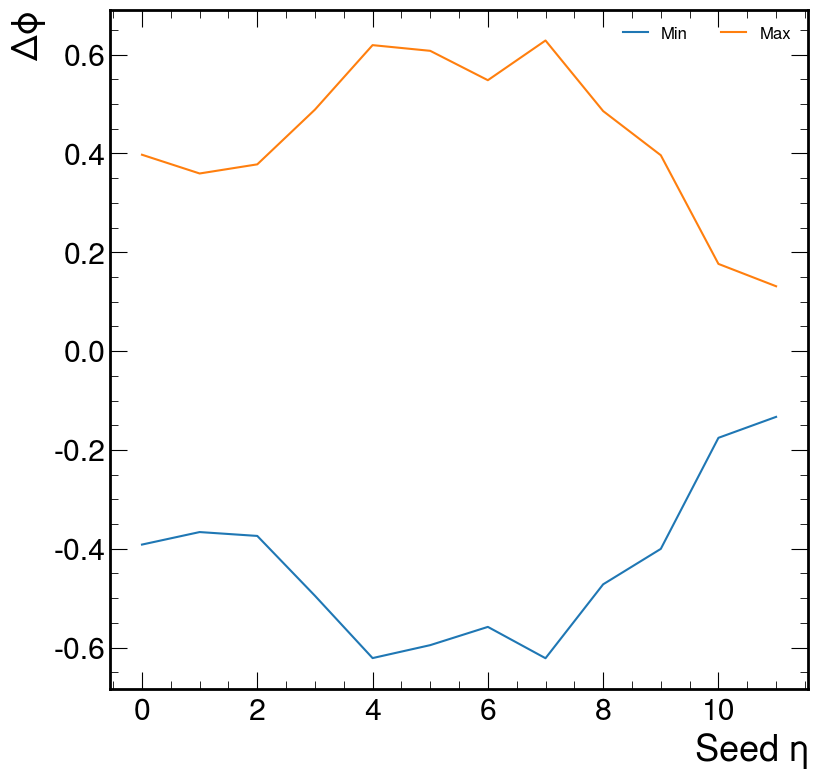

In [101]:
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
ax.plot(maxWS_eo.ieta, maxWS_eo.dphi_min, label="Min")
ax.plot(maxWS_eo.ieta, maxWS_eo.dphi_max, label="Max")

ax.legend(ncol=3, fontsize="12")
#ax.set_xticklabels(etas)
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\phi$")

Text(0, 1, '$\\Delta\\eta$')

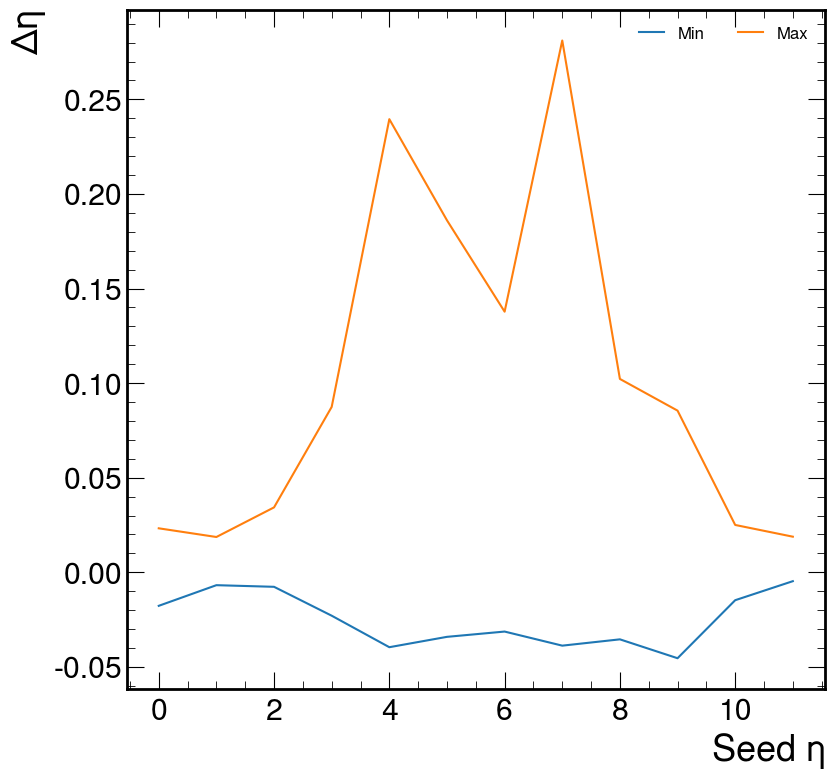

In [102]:
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)

ax.plot(maxWS_eo.ieta, maxWS_eo.deta_min, label="Min")
ax.plot(maxWS_eo.ieta, maxWS_eo.deta_max, label="Max")

ax.legend(ncol=3, fontsize="12")
#ax.set_xticklabels(etas)
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\eta$")